# Waterloo Takeoff Data Source Code

## Imports and File Processing

In [1]:
# %matplotlib widget (Only for 3D plot)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import math
from sklearn.linear_model import LinearRegression
import matplotlib.colors as mcolors
import time
from scipy.stats import linregress
import datetime
from scipy.ndimage import gaussian_filter1d
import re
from math import *
from haversine import haversine
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor



In [2]:
%%time

def bearing(coord1: object, coord2: object):
    
    lat1, lon1 = coord1
    lat2, lon2 = coord2

    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)
    
    dlon = lon2 - lon1
    
    x = math.sin(dlon) * math.cos(lat2)
    y = (math.cos(lat1) * math.sin(lat2)) - (math.sin(lat1) * math.cos(lat2) * math.cos(dlon))

    bearing = math.atan2(x, y)
    bearing = math.degrees(bearing)
    bearing = (bearing + 360) % 360
    
    return bearing


colormap = plt.colormaps['tab20']
subfolders = [f.path for f in os.scandir(r'C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight') if f.is_dir()] #Scans Directory
total_subfolders = len(subfolders)

# Stores a csv cols into a list
soh_list1 = []
soh_list2 = []
df_time_list = []
df_kw_list = []
df_alt_list = []
df_soc_list = []
df_oat_list = []
df_pitch_list = []
df_roll_list = []
df_speed_list = []
df_soh_list = []
df_battT_list = []
power_sum = [0,0,0]
time_sum = [0,0,0]
df_lat_list = []
df_long_list = []
df_wSpeed_list = []
df_wDir_list = []
df_date_list = []  # List to store the extracted dates
df_heading_list = []

df_wind = pd.read_csv(r"C:\Users\Nathan\Documents\PipistrelData\WaterlooWindspeed\WindData.csv")
df_wind["LOCAL_DATE"] = df_wind["LOCAL_DATE"].apply(
    lambda x: re.sub(r' (\d{1}):', lambda m: ' 0' + m.group(1) + ':', x)
)



# Iterates and read each csv
mask = pd.DataFrame(columns=['mask'], index=range(total_subfolders))
mask['mask'] = True
for i, subfolder in enumerate(subfolders):
    csv_files = glob.glob(os.path.join(subfolder, '*.csv'))
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True) #Status Print
    main_csv = csv_files[0]
    with open(main_csv) as f:
        total_rows = sum(1 for line in f)
    # Skips every 10 rows for efficiency (1 sec iterations estimate)
    skip_rows = [i for i in range(1, total_rows) if i % 10 != 0]
    df_csv = pd.read_csv(main_csv,skiprows=skip_rows)
    
    index1 = df_csv[' LAT'].ne(0).idxmax()
    index2 = df_csv[' LAT'].loc[df_csv[' LAT'].index > index1].ne(df_csv[' LAT'].iloc[index1]).idxmax()
    
    if df_csv[' LAT'].iloc[index1] == 0 or df_csv[' LAT'].iloc[index2] == 0:
        mask.loc[i, 'mask'] = False
        
        soh_list1.append(np.nan)
        soh_list2.append(np.nan)
        df_time_list.append(np.nan)
        df_kw_list.append(np.nan)
        df_alt_list.append(np.nan)
        df_soc_list.append(np.nan)
        df_oat_list.append(np.nan)
        df_pitch_list.append(np.nan)
        df_roll_list.append(np.nan)
        df_speed_list.append(np.nan)
        df_soh_list.append(np.nan)
        df_battT_list.append(np.nan)
        df_lat_list.append(np.nan)
        df_long_list.append(np.nan)
        df_heading_list.append(np.nan)
        df_wSpeed_list.append(np.nan)
        df_wDir_list.append(np.nan)
        df_date_list.append(np.nan)
        
        continue
   
    
    # Extracts the date from the subfolder name using regular expressions
    date_match = re.search(r'\d{4}[a-zA-Z]{3}\d{2}', subfolder)
    if date_match:
        date = date_match.group()
        time_match = re.search(r'\d{4}[a-zA-Z]{3}\d{2}_(\d{2})(\d{2})([ap]m)', subfolder)
        if time_match:
            hour = int(time_match.group(1))
            minute = int(time_match.group(2))
            am_pm = time_match.group(3)
            if am_pm.lower() == 'pm' and hour != 12:
                hour += 12
            elif am_pm.lower() == 'am' and hour == 12:
                hour = 0
            time = datetime.time(hour, minute)
            date_time_obj = datetime.datetime.strptime(date, '%Y%b%d')
            date_time_combined = datetime.datetime.combine(date_time_obj, time)
            
            # Round to nearest hour
            if date_time_combined.minute >= 30:
                date_time_combined = date_time_combined + datetime.timedelta(hours=1)
            date_time_rounded = date_time_combined.replace(minute=0, second=0, microsecond=0)
            
            date_time_str = date_time_rounded.strftime('%Y-%m-%d %H:%M')
            df_date_list.append(date_time_str)
            
            # Use .loc and boolean indexing to find the row
            matching_row = df_wind.loc[df_wind["LOCAL_DATE"].str.contains(date_time_str)]
            matched_index = matching_row.index[0]
            
            if not matching_row.empty:
                wind_speed = matching_row.iloc[0]["WIND_SPEED"]
                wind_direction = (matching_row.iloc[0]["WIND_DIRECTION"])*10
                added_rows = 0
                while np.isnan(wind_direction) or np.isnan(wind_speed):
                    added_rows += 1
                    wind_speed = df_wind.iloc[matched_index+added_rows]["WIND_SPEED"]
                    wind_direction = (df_wind.iloc[matched_index+added_rows]["WIND_DIRECTION"])*10
                    
                df_wSpeed_list.append(wind_speed)
                df_wDir_list.append(wind_direction)
                    
            else:
                df_wSpeed_list.append(np.nan)
                df_wDir_list.append(np.nan)
           
            
    df_soh = (df_csv[' bat 1 soh'])
    df_soh_list.append(df_soh)
    df_time_list.append(df_csv[" time(min)"])
    df_kw_list.append(df_csv[" motor power"])
    df_soc_list.append(df_csv[" bat 1 soc"])
    df_oat_list.append(df_csv[" OAT"])
    df_pitch_list.append(df_csv[" PITCH"])
    df_roll_list.append(df_csv[" ROLL"])
    df_speed_list.append(df_csv[" GROUND_SPEED"])
    df_lat_list.append(df_csv[" LAT"])
    df_long_list.append(df_csv[" LNG"])
    

    # heading_offset = bearing((df_csv[" LAT"].iloc[index1], df_csv[" LNG"].iloc[index1]), (df_csv[" LAT"].iloc[index2], df_csv[" LNG"].iloc[index2]))
    # df_heading_list.append((df_csv[" HEADING"] + heading_offset - df_csv[" HEADING"].iloc[index1]) % 360)
    df_heading_list.append(df_csv[" HEADING"])
    
    
    # print(df_csv[" HEADING"].iloc[index1])
    # print(heading_offset)
    
    
    

    df_battT = 0
    for i in range(1, 17):
        df_battT += df_csv[f" bat 1 cell {i} temp"] 
        df_battT += df_csv[f" bat 2 cell {i} temp"] 
    df_battT = df_battT/32 
    df_battT_list.append(df_battT)
    
    
    
    # Calibrates alt to ground alt and converts m to ft
    df_csv[" PRESSURE_ALT"] = (df_csv[" PRESSURE_ALT"]-df_csv[" PRESSURE_ALT"].iloc[-1])*3.28084
    df_csv[" PRESSURE_ALT"] = df_csv[" PRESSURE_ALT"].where(df_csv[" PRESSURE_ALT"]>=0, 0)
    df_alt_list.append(df_csv[" PRESSURE_ALT"])
    
soh_list1.append(df_csv.loc[df_csv[' bat 1 soh'] != 0, ' bat 1 soh'].iloc[0])
soh_list2.append(df_csv.loc[df_csv[' bat 2 soh'] != 0, ' bat 2 soh'].iloc[0])
df_soh1 = pd.DataFrame({"bat1": soh_list1})
df_soh2 = pd.DataFrame({"bat2": soh_list2})

# Main df
df_power = pd.DataFrame({"date": df_date_list, "wind speed": df_wSpeed_list, "wind dir": df_wDir_list, "time": df_time_list, "kw": df_kw_list, "alt": df_alt_list, "soc": df_soc_list, "oat": df_oat_list, "pitch": df_pitch_list, "roll": df_roll_list, "speed": df_speed_list, "soh": df_soh_list, "battT": df_battT_list, "lat":df_lat_list, "long": df_long_list,'heading': df_heading_list})   

print('')


Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-26897-6263_2024jun03_0920pm_dc [100%]
CPU times: total: 18.4 s
Wall time: 39.3 s


## Flight Stages

In [14]:
import numpy as np
from numpy.lib.stride_tricks import as_strided

def rolling_mean(arr, window):
    # Ensure the window size is valid
    if window > len(arr):
        raise ValueError("Window size must be less than or equal to array length")

    # Calculate the strides
    shape = (len(arr) - window + 1, window)
    strides = (arr.strides[0], arr.strides[0])

    # Create a rolling view of the array
    rolling_windows = as_strided(arr, shape=shape, strides=strides)
    
    # Calculate mean for each window
    return np.mean(rolling_windows, axis=1)



### Stage Visualization

Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-20815-4620_2023jun03_1011am_dc [1%]

<Figure size 1200x400 with 0 Axes>

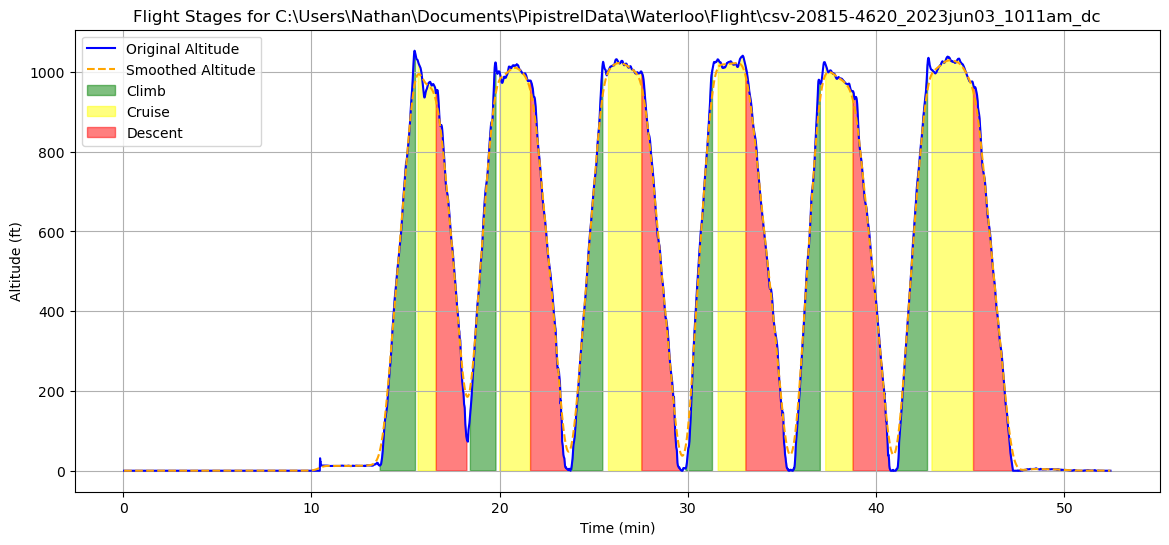

Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-20821-4622_2023jun04_1025am_dc [1%]

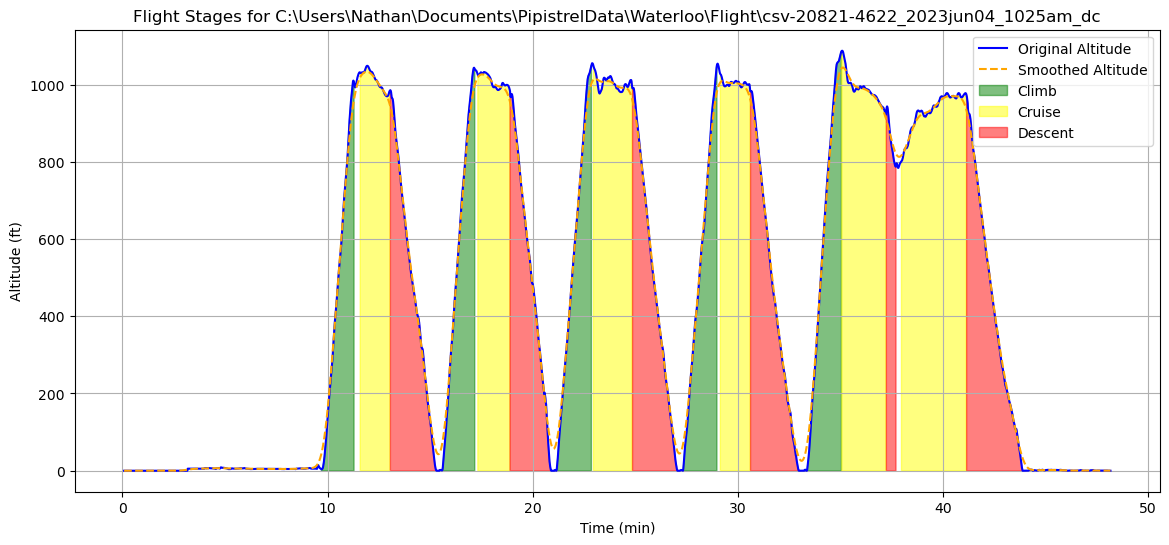

Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-20871-4633_2023jun09_0237pm_dc [2%]

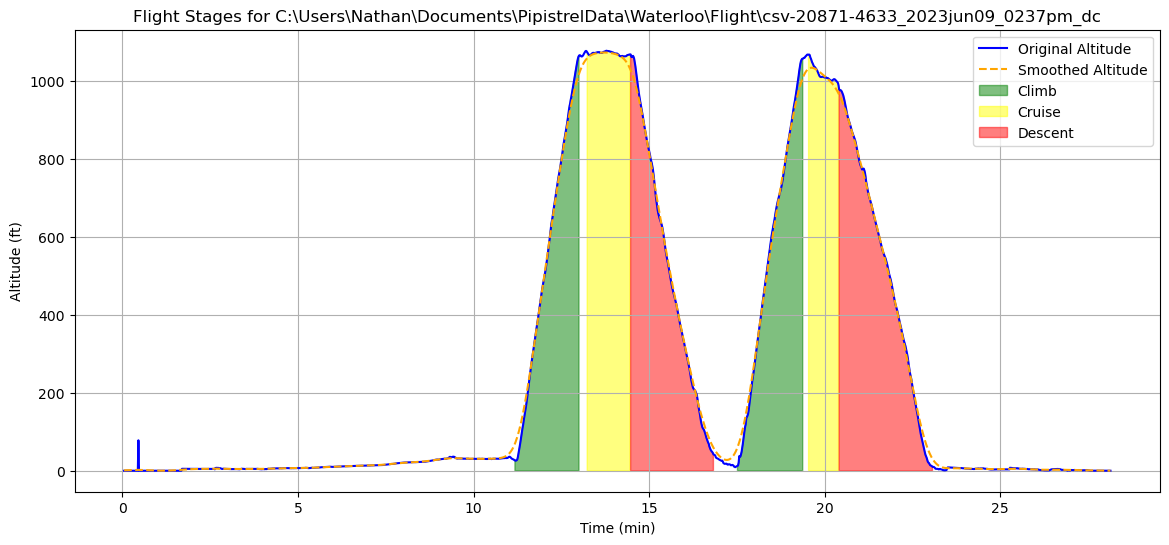

Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-20882-4636_2023jun11_1012am_dc [2%]

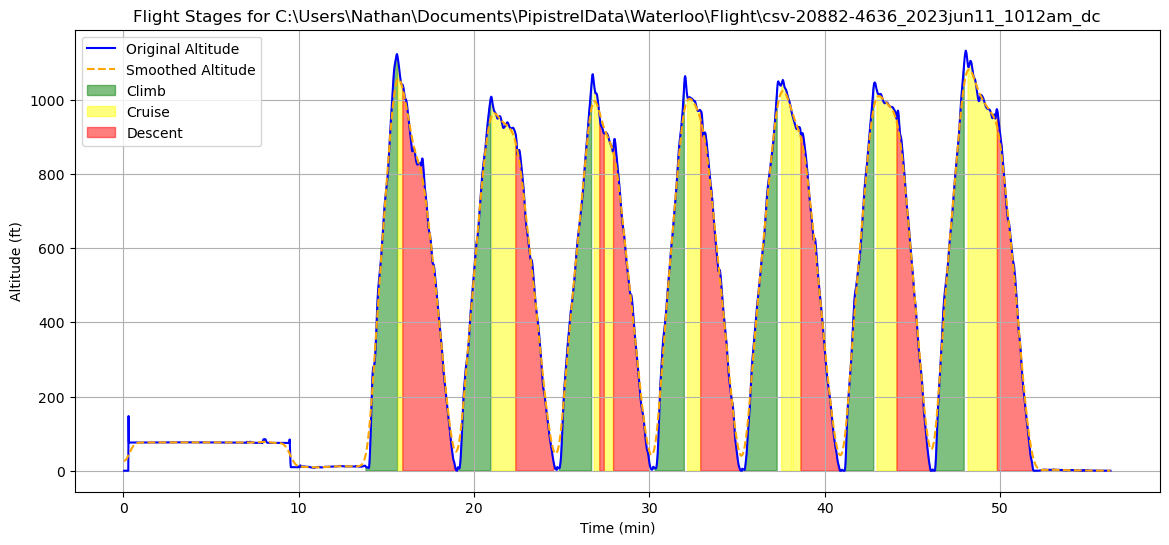

Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-21003-4669_2023jun21_1038am_dc [3%]

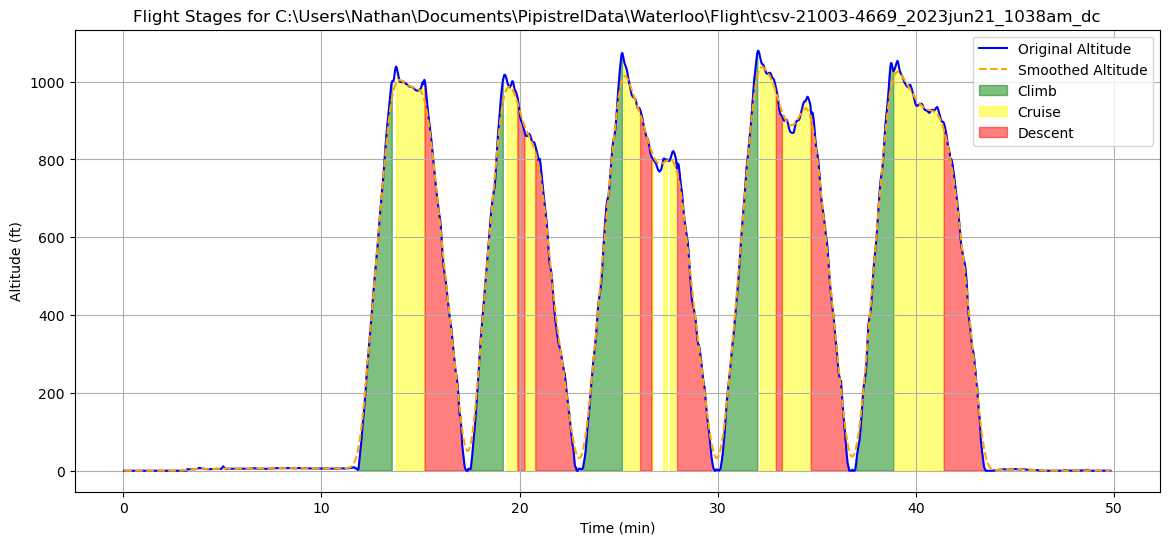

Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-21443-4759_2023jul11_0956am_dc [3%]

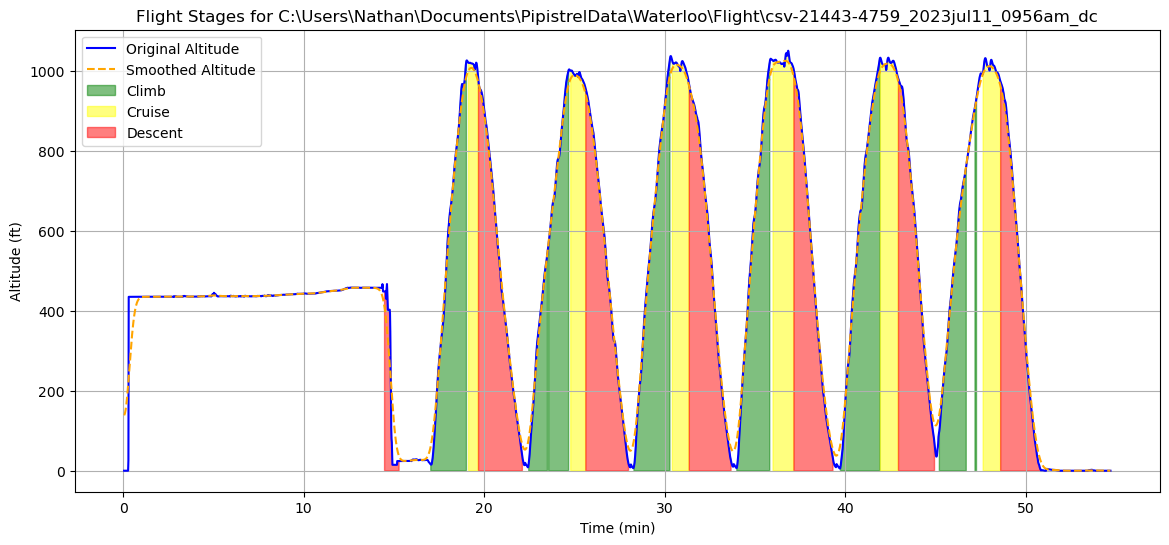

Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-21445-4714_2023jul05_0949am_dc [4%]

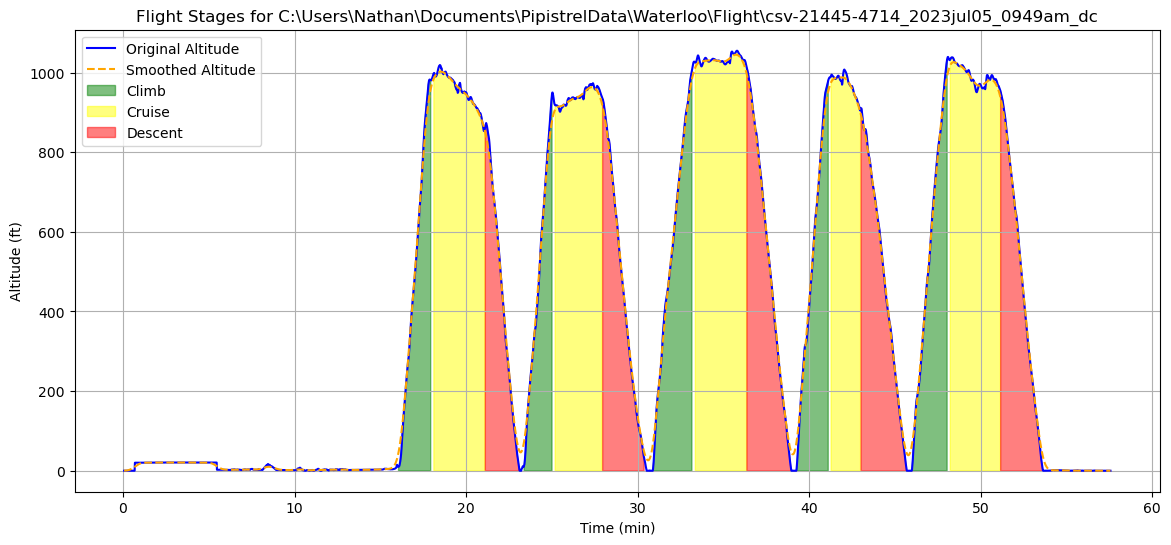

Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-21465-4766_2023jul20_0954am_dc [5%]

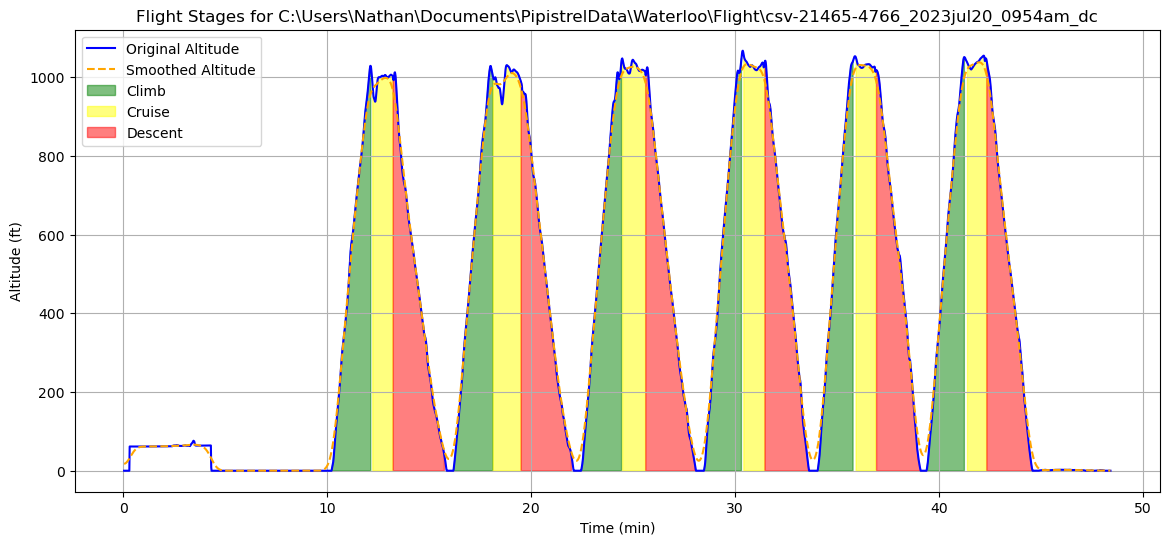

Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-21514-4783_2023jul30_1001am_dc [6%]

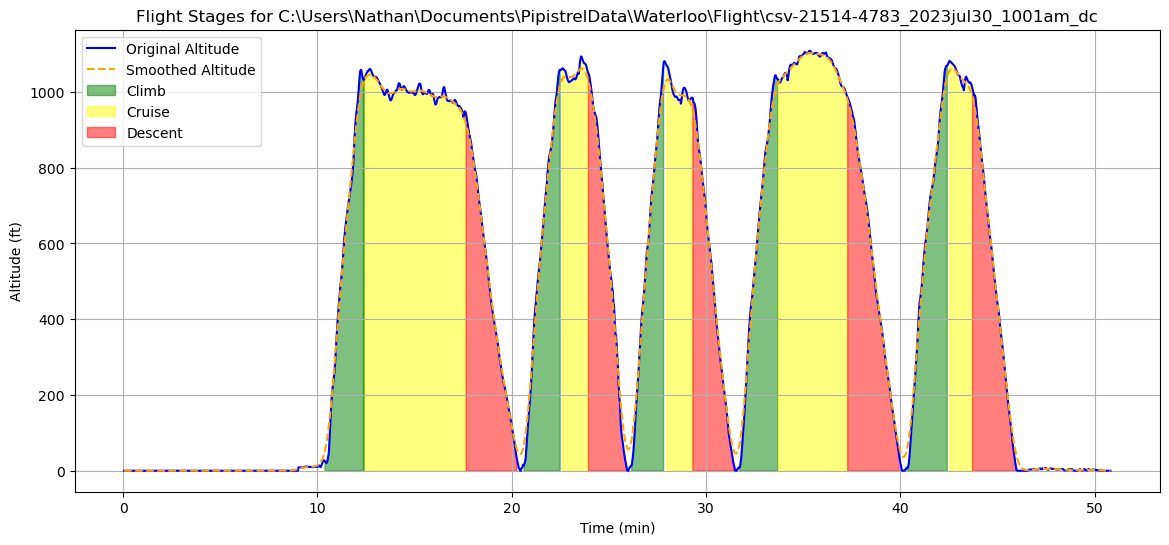

Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-21817-4862_2023aug31_1130am_dc [11%]

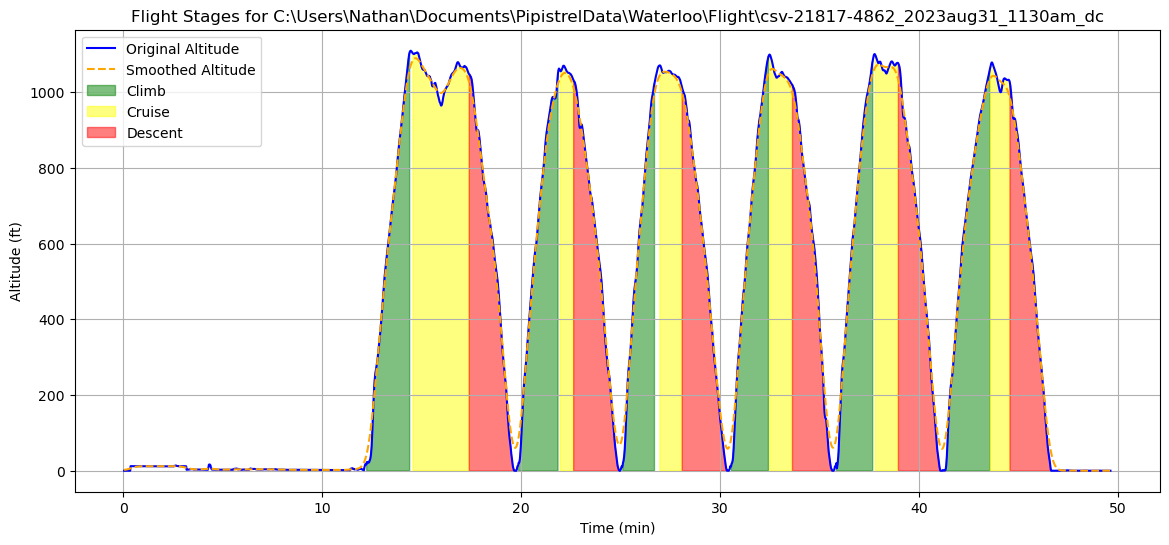

Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-21835-4871_2023aug31_1130am_dc [12%]

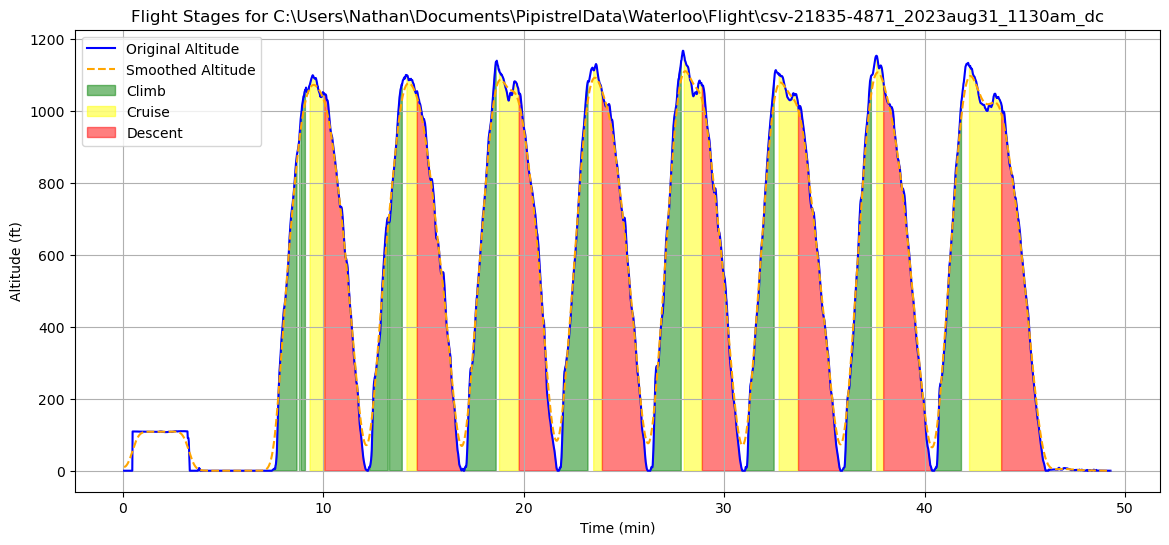

Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-21864-4842_2023aug22_1025am_dc [13%]

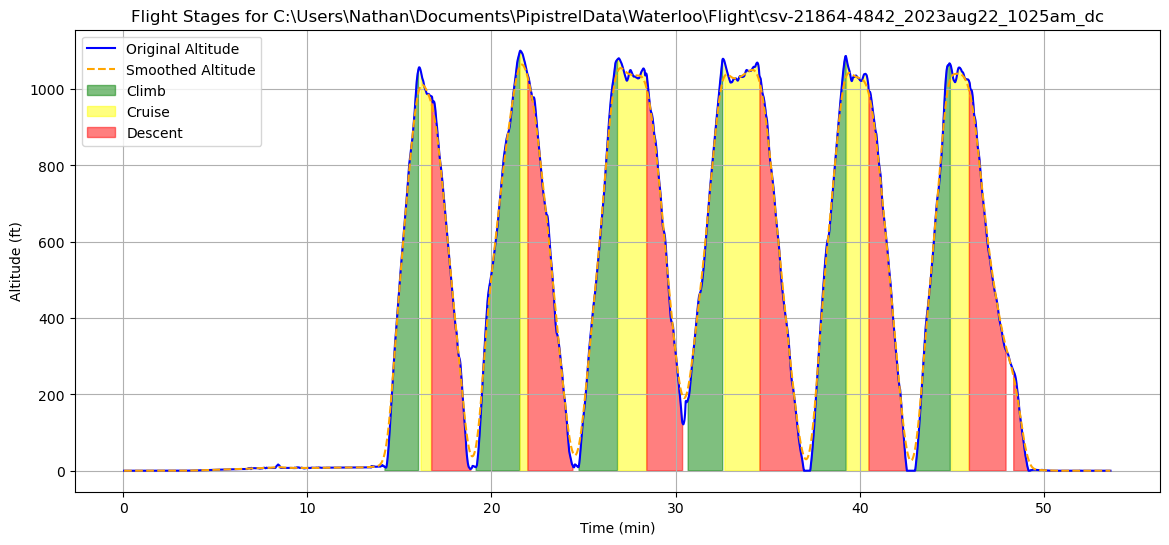

Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-21868-4845_2023aug22_1025am_dc [14%]

KeyboardInterrupt: 

In [50]:
cell_diff = 125
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))


colors = [(0, 1, 0), (0, 1, 0.33), (0, 0.5, 0.66), (0, 0.25, 0.66)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=5, vmax=25)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH'])

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush=True)
    if not mask.loc[i, 'mask']:
        continue
    df = df_power.iloc[i].copy()
    
    if df["alt"].max() < 1300 and df["alt"].max() > 200:
       
        df["smoothed_alt"] = pd.Series(gaussian_filter1d(df["alt"], sigma=15))
        
        df['rate_of_change'] = df['smoothed_alt'].diff() / df['time'].diff()

        df['moving'] = df['rate_of_change'].rolling(window=10).mean()
        
        
        takeoff_threshold = 150
        landing_threshold = -150
        cruise_threshold = 149
        
        
        df["takeoff"] = (
                (df["moving"] > takeoff_threshold) &
                (df["kw"] > 30) &
                (df["alt"] > 0) &
                (df["alt"] < 1300)
            )  
        df["landing"] = (
            ((df["alt"] >= 750) & (df["moving"] < landing_threshold)) | 
            ((df["alt"] < 750) & (df["moving"] < landing_threshold - 50))
        )
        df["cruise"] = (~df["takeoff"]) & (~df["landing"]) & (abs(df["moving"]) < cruise_threshold) & (df["alt"] > 800)
        
        plt.figure(figsize=(14, 6))
        plt.plot(df["time"], df["alt"], label='Original Altitude', color='blue')
        plt.plot(df["time"], df["smoothed_alt"], label='Smoothed Altitude', linestyle='--', color='orange')
        
        
        plt.fill_between(df["time"], df["alt"], where=df["takeoff"], color='green', alpha=0.5, label='Climb')
        plt.fill_between(df["time"], df["alt"], where=df["cruise"], color='yellow', alpha=0.5, label='Cruise')
        plt.fill_between(df["time"], df["alt"], where=df["landing"], color='red', alpha=0.5, label='Descent')
        
        plt.legend()
        plt.xlabel('Time (min)')
        plt.ylabel('Altitude (ft)')
        plt.title(f'Flight Stages for {subfolder}')
        plt.grid(True)
        plt.show()
        
print("Processing complete.")


### Functions

In [4]:
def angle_offset(coord1, coord2,df,idx1):
    strip_angle = [138,318,75,255]
    initial_angle = bearing(coord1, coord2)
    closest_angle = min(strip_angle, key=lambda d: abs(d - initial_angle))
    heading_angle = df["heading"][idx1]
    offset_angle = closest_angle-heading_angle
    return offset_angle

In [5]:
def set_offset_angle(df):
    bool_series = df["takeoff"]
    true_indices = bool_series[bool_series].index 
    offset_angle = None
    if len(true_indices) > 1:
        for j in range(len(true_indices) - 1):
            idx1 = true_indices[j]
            idx2 = true_indices[j + 1]
            if idx2 - idx1 == 1:
                lat1, lon1 = df['lat'].iloc[idx1], df['long'].iloc[idx1]
                lat2, lon2 = df['lat'].iloc[idx2], df['long'].iloc[idx2]
                coord1, coord2 = [lat1, lon1], [lat2, lon2]
                if coord1 != coord2:
                    distance = haversine(coord1, coord2)
                    if distance != 0:
                        climb_diff = (df['alt'][idx2] - df['alt'][idx1])
                        if climb_diff !=0:
                            offset_angle = angle_offset(coord1, coord2,df,idx1)
                            break
    return offset_angle   
                    
                    
        

In [6]:
def process_flight_data(df, flight_stage, df_slope):
    
    offset_angle = set_offset_angle(df)
    if offset_angle is None:
        return
    
    stage_name = ""
    if flight_stage.equals(df["takeoff"]):
        stage_name = "takeoff"
    elif flight_stage.equals(df["cruise"]):
        stage_name = "cruise"
    elif flight_stage.equals(df["landing"]):
        stage_name = "landing"
    
    bool_series = flight_stage
    true_indices = bool_series[bool_series].index

    if len(true_indices) > 1:
        avg_power_list = []
        energy_differences = []
        time_per_climb_list = []
        avg_oat_list = []
        avg_soh_list = []
        total_distance = 0
        adjusted_energy = []
        avg_headwind_list = []
        total_energy = 0
        total_time = 0
        
        # first_run = True
        # offset_angle = None
        
        # Calculate average power, energy, time, OAT, SOH for each climb segment
        for j in range(len(true_indices) - 1):
            idx1 = true_indices[j]
            idx2 = true_indices[j + 1]

            if idx2 - idx1 == 1:
                lat1, lon1 = df['lat'].iloc[idx1], df['long'].iloc[idx1]
                lat2, lon2 = df['lat'].iloc[idx2], df['long'].iloc[idx2]
                coord1, coord2 = [lat1, lon1], [lat2, lon2]
                time_difference = (df['time'][idx2] - df['time'][idx1]) / 60
                total_time += time_difference
                if coord1 != coord2:
                    distance = haversine(coord1, coord2)
                    if distance != 0:
                        climb_diff = (df['alt'][idx2] - df['alt'][idx1])
                        if climb_diff != 0:
                            total_distance += distance
                            
                            avg_power = (df['kw'][idx1] + df['kw'][idx2]) / 2
                            avg_power_list.append(avg_power)
                            energy = avg_power * time_difference
                            total_energy += energy  
                            energy_per_km = (energy) / distance
                            energy_differences.append(energy_per_km)
                            avg_oat = (df['oat'][idx1] + df['oat'][idx2]) / 2
                            avg_oat_list.append(avg_oat)
                            avg_soh = (df['soh'][idx1] + df['soh'][idx2]) / 2
                            avg_soh_list.append(avg_soh) 
                            time_per_climb_list.append(time_difference/climb_diff)
                            
            
                            
                            
                            
                            
                            resultant_velocity = distance / time_difference
                            resultant_angle = bearing(coord1, coord2)
                            # if first_run and stage_name == "takeoff":
                            #     offset_angle = angle_offset(coord1, coord2,df,idx1)
                            #     first_run = False
                                
                            plane_angle = df['heading'][idx1]+offset_angle
                            # print(resultant_angle)
                            wind_velocity = df['wind speed']
                            wind_direction = df['wind dir']
                            
                            # headwind = wind_velocity * math.cos(math.radians(resultant_angle - wind_direction))
                            
                            plane_angle_rad = math.radians(plane_angle) 
                            wind_direction_rad = math.radians(wind_direction)  
                            angle_difference_rad = wind_direction_rad - plane_angle_rad
                            headwind = -(wind_velocity * math.cos(angle_difference_rad))
                            # print(headwind)
                            initial_velocity = resultant_velocity + headwind
                            adjusted_time = distance / initial_velocity
                            adjusted_energy.append((avg_power * adjusted_time) / distance)
                            avg_headwind_list.append(headwind)
                            # print(resultant_angle)
                            
                            
            else:
                if energy_differences:
                    power_per_circuit = np.mean(avg_power_list)
                    oat_per_circuit = np.mean(avg_oat_list)
                    soh_per_circuit = np.mean(avg_soh_list)
                    kWh_per_km = np.mean(energy_differences)
                    hr_per_1000ft = np.mean(time_per_climb_list)
                    adj_kWh_per_km = np.mean(adjusted_energy)
                    avg_headwind = np.mean(avg_headwind_list)
                    # kWh = np.mean(total_energy)
                    kWh = power_per_circuit * total_time
                    
                    
                    # # Check conditions for valid data and add to df_slope
                    # if kWh_per_km < 1.5 and abs(hr_per_1000ft) < 0.05 and total_distance < 10 and total_distance > 0.05:
                    #     if stage_name == "landing" and power_per_circuit > 10: 
                    #         pass
                    #     else:
                    if adj_kWh_per_km < 1 and adj_kWh_per_km > 0 and total_time > 0.0075:
                        df_slope.loc[len(df_slope)] = {
                            "Avg Power": power_per_circuit,
                            "Energy/km": kWh_per_km,
                            "Adjusted Energy/km": adj_kWh_per_km,
                            "Avg Headwind": avg_headwind,
                            "Time/ft": hr_per_1000ft,
                            "Energy": kWh,  
                            "Distance": total_distance,
                            "Total Energy":power_per_circuit*hr_per_1000ft,
                            "Average OAT": oat_per_circuit,
                            "SoH": soh_per_circuit,
                            "Stage": stage_name
                        }
                        avg_power_list = []
                        energy_differences = []
                        time_per_climb_list = []
                        avg_oat_list = []
                        avg_soh_list = []
                        total_distance = 0
                        adjusted_energy = []
                        avg_headwind_list = []
                        total_energy = 0
                        total_time = 0

        if energy_differences:  
            power_per_circuit = np.mean(avg_power_list)
            oat_per_circuit = np.mean(avg_oat_list)
            soh_per_circuit = np.mean(avg_soh_list)
            kWh_per_km = np.mean(energy_differences)
            hr_per_1000ft = np.mean(time_per_climb_list)
            adj_kWh_per_km = np.mean(adjusted_energy)
            avg_headwind = np.mean(avg_headwind_list)
            # kWh = np.mean(total_energy)
            kWh = power_per_circuit * total_time

            
            
            if adj_kWh_per_km < 1 and adj_kWh_per_km > 0 and total_time > 0.0075:
            
                df_slope.loc[len(df_slope)] = {
                    "Avg Power": power_per_circuit,
                    "Energy/km": kWh_per_km,
                    "Adjusted Energy/km": adj_kWh_per_km,
                    "Avg Headwind": avg_headwind,
                    "Time/ft": hr_per_1000ft,
                    "Energy": kWh,      
                    "Distance": total_distance,
                    "Average OAT": oat_per_circuit,
                    "Total Energy":power_per_circuit*hr_per_1000ft,
                    "SoH": soh_per_circuit,
                    "Stage": stage_name
                }
                
    return df_slope


In [7]:
def file_iterate(df_slope, stage, min_alt = 0, max_alt = 1300):
    for i, subfolder in enumerate(subfolders):
        print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush=True)
        if not mask.loc[i, 'mask']:
            continue
        
        df = df_power.iloc[i].copy()
        
        if df["alt"].max() < 1300 and df["alt"].max() > 200:

            df["smoothed_alt"] = gaussian_filter1d(df["alt"], sigma=15)
            df["gradient"] = np.gradient(df["smoothed_alt"], df["time"])
        
            takeoff_threshold = 150
            landing_threshold = -150
            cruise_threshold = 149
        
            df["takeoff"] = (
                (df["gradient"] > takeoff_threshold) &
                (df["kw"] > 30) &
                (df["alt"] > min_alt) &
                (df["alt"] < max_alt)
            )  
             
            df["landing"] = (
            ((df["alt"] >= 750) & (df["gradient"] < landing_threshold)) | 
            ((df["alt"] < 750) & (df["gradient"] < landing_threshold - 50))
        )
            df["cruise"] = (~df["takeoff"]) & (~df["landing"]) & (abs(df["gradient"]) < cruise_threshold) & (df["alt"] > 800)
            process_flight_data(df, df[stage], df_slope)

### Graphical Functions

#### Takeoff Seperated

Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-26897-6263_2024jun03_0920pm_dc [100%]
Plotting...
218


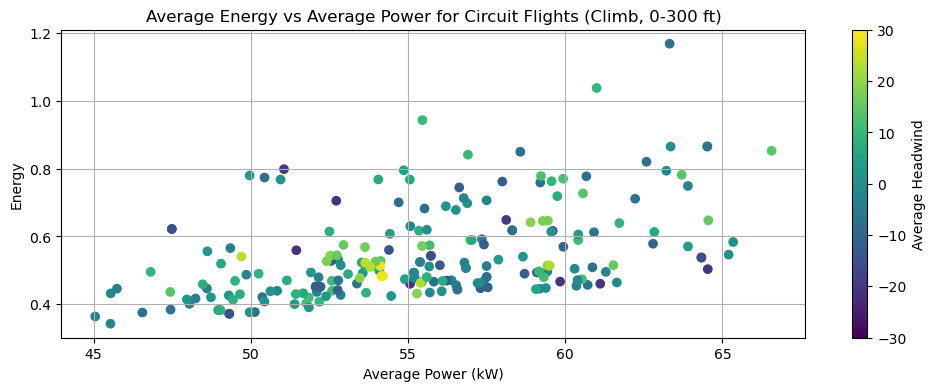

C:\Users\Nathan\AppData\Local\Temp\ipykernel_14672\1053656350.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Power Bin'] = pd.cut(filtered_df['Avg Power'], bins)


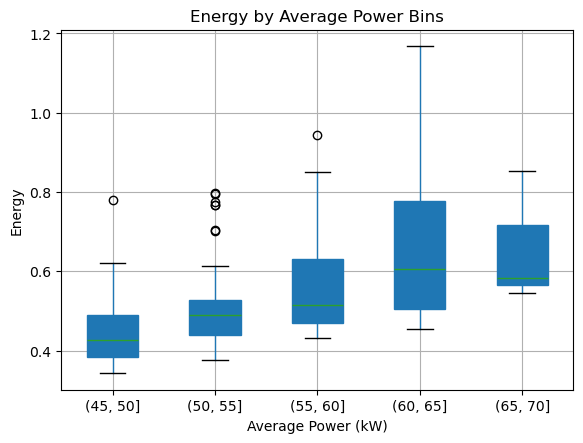

Box Plot Summary Statistics:
           count      mean       std       min       25%       50%       75%  \
Power Bin                                                                      
(45, 50]    32.0  0.454264  0.094526  0.342729  0.383166  0.427991  0.489424   
(50, 55]    65.0  0.510683  0.101809  0.377100  0.439736  0.488941  0.528548   
(55, 60]    85.0  0.564643  0.116097  0.431421  0.470832  0.515124  0.630084   
(60, 65]    33.0  0.648586  0.178418  0.454472  0.504846  0.605950  0.777241   
(65, 70]     3.0  0.660899  0.167113  0.546419  0.565016  0.583612  0.718139   

                max  
Power Bin            
(45, 50]   0.779568  
(50, 55]   0.798366  
(55, 60]   0.942943  
(60, 65]   1.168135  
(65, 70]   0.852666  


C:\Users\Nathan\AppData\Local\Temp\ipykernel_14672\1053656350.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = filtered_df.groupby('Power Bin')['Energy'].describe()


Avg Power  Energy/km  Adjusted Energy/km  Avg Headwind       Time/ft  \
0    51.448718   0.408977            0.493550    -20.957756  1.327489e-04   
1    52.718750   0.367403            0.430997    -20.982595  3.274570e-05   
2    64.535714   0.463699            0.549025    -20.978588 -7.590714e-06   
3    59.839286   0.425386            0.501584    -20.992296 -6.924736e-07   
4    55.066667   0.381395            0.446510    -20.975479  1.064239e-04   
..         ...        ...                 ...           ...           ...   
216  46.815789   0.165217            0.159970      9.257318  3.787914e-05   
217  49.500000   0.178931            0.173326      8.919300  3.522458e-05   
218  56.571429   0.235653            0.242795     -7.029720  4.798928e-05   
219  57.500000   0.233552            0.240399     -6.977512  2.969371e-05   
220  64.520833   0.252598            0.259521     -6.804298  2.624239e-05   

       Energy  Distance  Average OAT   SoH    Stage Power Bin  
0    0.559348  1.398516    19.506410  97.0  takeoff  (50, 55]  
1    0.705234  1.937075    19.838542  97.0  takeoff  (50, 55]  
2    0.503576  1.111900    19.741071  97.0  takeoff  (60, 65]  
3    0.466846  1.123618    19.741071  97.0  takeoff  (55, 60]  
4    0.460272  1.212384    19.791667  97.0  takeoff  (55, 60]  
..        ...       ...          ...   ...      ...       ...  
216  0.495654  1.508657    18.342105  74.0  takeoff  (45, 50]  
217  0.468985  1.328889    18.176471  74.0  takeoff  (45, 50]  
218  0.443728  0.945023    26.428571  71.0  takeoff  (55, 60]  
219  0.480557  1.045077    24.033333  71.0  takeoff  (55, 60]  
220  0.865271  1.721415    23.666667  71.0  takeoff  (60, 65]  

[218 rows x 11 columns]

In [8]:
def stage_one_takeoff():
    
    plt.figure(figsize=(12, 4))

    df_slope = pd.DataFrame(columns=['Avg Power', 'Energy/km', 'Adjusted Energy/km', 'Avg Headwind', 'Time/ft','Energy', 'Distance', 'Average OAT','SoH',"Stage"])
    
    file_iterate(df_slope, "takeoff", min_alt=0, max_alt=300)
                    
    print('')
    print("Plotting...")
    
    filtered_df = df_slope
    filtered_df = filtered_df[(filtered_df['Energy'] < 1.5) & (filtered_df['Energy/km'] > 0.05)]
    
    print(len(filtered_df))
    colors = plt.cm.viridis(np.linspace(0, 1, len(filtered_df)))
    custom_colormap = mcolors.ListedColormap(colors)
    norm = mcolors.Normalize(vmin=-30, vmax=30)
    plt.scatter(
    filtered_df["Avg Power"], 
    filtered_df["Energy"],
    marker='o', 
    c=filtered_df["Avg Headwind"], 
    cmap=custom_colormap, 
    norm=norm
)

    plt.colorbar(label='Average Headwind', cmap=custom_colormap, norm=norm)
    plt.xlabel('Average Power (kW)')
    plt.ylabel('Energy')
    plt.title('Average Energy vs Average Power for Circuit Flights (Climb, 0-300 ft)')
    plt.grid(True)
    plt.show()
    
    
    # Box Plots
    bins = np.arange(45, 75, 5)
    filtered_df['Power Bin'] = pd.cut(filtered_df['Avg Power'], bins)

    filtered_df.boxplot(column='Energy', by='Power Bin', grid=False, patch_artist=True)

    plt.xlabel('Average Power (kW)')
    plt.ylabel('Energy')
    plt.title('Energy by Average Power Bins')
    plt.suptitle('')
    plt.grid(True)
    plt.show()
    summary = filtered_df.groupby('Power Bin')['Energy'].describe()
    print("Box Plot Summary Statistics:")
    print(summary)
    
    return filtered_df
    
    

stage_one_takeoff()


Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-26897-6263_2024jun03_0920pm_dc [100%]
Plotting...
194


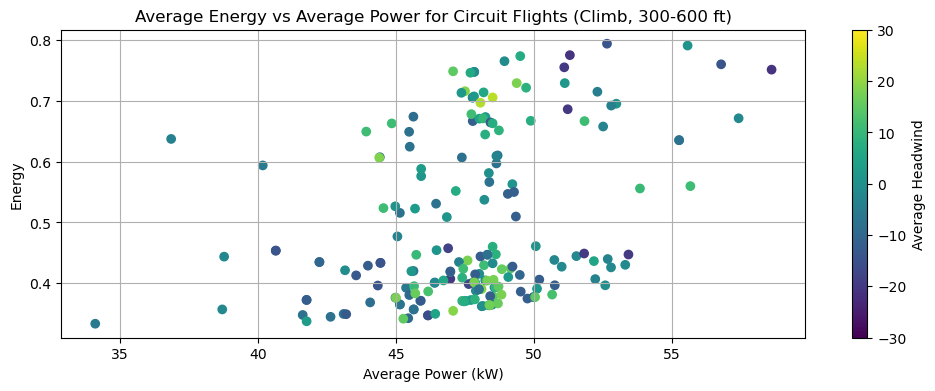

C:\Users\Nathan\AppData\Local\Temp\ipykernel_14672\2935724513.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Power Bin'] = pd.cut(filtered_df['Avg Power'], bins)


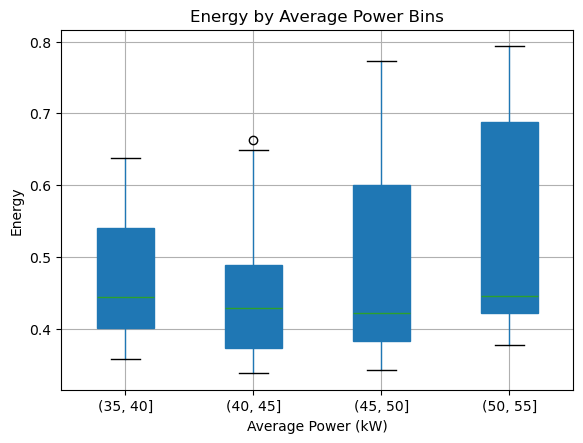

Box Plot Summary Statistics:
           count      mean       std       min       25%       50%       75%  \
Power Bin                                                                      
(35, 40]     3.0  0.479335  0.143508  0.356978  0.400357  0.443735  0.540514   
(40, 45]    27.0  0.446971  0.099303  0.337521  0.372571  0.428921  0.488611   
(45, 50]   128.0  0.487311  0.131575  0.341703  0.382785  0.421661  0.599483   
(50, 55]    28.0  0.531326  0.146639  0.377215  0.421287  0.445953  0.687617   

                max  
Power Bin            
(35, 40]   0.637292  
(40, 45]   0.662832  
(45, 50]   0.773465  
(50, 55]   0.793838  


C:\Users\Nathan\AppData\Local\Temp\ipykernel_14672\2935724513.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = filtered_df.groupby('Power Bin')['Energy'].describe()


Avg Power  Energy/km  Adjusted Energy/km  Avg Headwind   Time/ft  \
0    53.416667   0.371516            0.431265    -19.863510  0.000031   
1    51.296296   0.346644            0.403675    -20.892992  0.000028   
2    58.597826   0.398598            0.464314    -20.819417  0.000023   
3    56.770833   0.364607            0.402302    -14.437242  0.000024   
4    52.640000   0.325955            0.358350    -14.206499  0.000026   
..         ...        ...                 ...           ...       ...   
192  48.229167   0.159474            0.155499      7.728480  0.000025   
193  47.464286   0.159033            0.155297      7.152548  0.000031   
194  48.312500   0.196233            0.202305     -7.367069  0.000034   
195  48.000000   0.192131            0.198034     -7.395073  0.000051   
196  55.250000   0.206516            0.212242     -7.175186  0.000022   

       Energy  Distance  Average OAT   SoH    Stage     Power Bin  
0    0.447260  1.205223    20.000000  97.0  takeoff  (50.0, 55.0]  
1    0.775059  2.235935    20.000000  97.0  takeoff  (50.0, 55.0]  
2    0.751224  1.886156    20.000000  97.0  takeoff           NaN  
3    0.759998  2.100965    12.421875  97.0  takeoff           NaN  
4    0.793838  2.367702    13.060000  97.0  takeoff  (50.0, 55.0]  
..        ...       ...          ...   ...      ...           ...  
192  0.644588  2.020090    18.500000  74.0  takeoff  (45.0, 50.0]  
193  0.370194  1.165122    18.392857  74.0  takeoff  (45.0, 50.0]  
194  0.446920  1.107399    25.687500  71.0  takeoff  (45.0, 50.0]  
195  0.390094  1.055591    24.183333  71.0  takeoff  (45.0, 50.0]  
196  0.635263  1.498745    23.925000  71.0  takeoff           NaN  

[194 rows x 11 columns]

In [9]:
def stage_two_takeoff():
    
    plt.figure(figsize=(12, 4))

    df_slope = pd.DataFrame(columns=['Avg Power', 'Energy/km', 'Adjusted Energy/km', 'Avg Headwind', 'Time/ft','Energy', 'Distance', 'Average OAT','SoH',"Stage"])
    
    file_iterate(df_slope, "takeoff", min_alt=300, max_alt=600)
                    
    print('')
    print("Plotting...")
    
    filtered_df = df_slope
    filtered_df = filtered_df[(filtered_df['Energy'] < 1) & (filtered_df['Energy/km'] > 0.05)]
    
    print(len(filtered_df))
    colors = plt.cm.viridis(np.linspace(0, 1, len(filtered_df)))
    custom_colormap = mcolors.ListedColormap(colors)
    norm = mcolors.Normalize(vmin=-30, vmax=30)
    plt.scatter(
    filtered_df["Avg Power"], 
    filtered_df["Energy"],
    marker='o', 
    c=filtered_df["Avg Headwind"], 
    cmap=custom_colormap, 
    norm=norm
)

    plt.colorbar(label='Average Headwind', cmap=custom_colormap, norm=norm)
    plt.xlabel('Average Power (kW)')
    plt.ylabel('Energy')
    plt.title('Average Energy vs Average Power for Circuit Flights (Climb, 300-600 ft)')
    plt.grid(True)
    plt.show()
    
    
    # Box Plots
    bins = np.arange(35, 60, 5)
    filtered_df['Power Bin'] = pd.cut(filtered_df['Avg Power'], bins)

    filtered_df.boxplot(column='Energy', by='Power Bin', grid=False, patch_artist=True)

    plt.xlabel('Average Power (kW)')
    plt.ylabel('Energy')
    plt.title('Energy by Average Power Bins')
    plt.suptitle('')
    plt.grid(True)
    plt.show()
    summary = filtered_df.groupby('Power Bin')['Energy'].describe()
    print("Box Plot Summary Statistics:")
    print(summary)
    
    return filtered_df
    
    

stage_two_takeoff()


Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-26897-6263_2024jun03_0920pm_dc [100%]
Plotting...
215


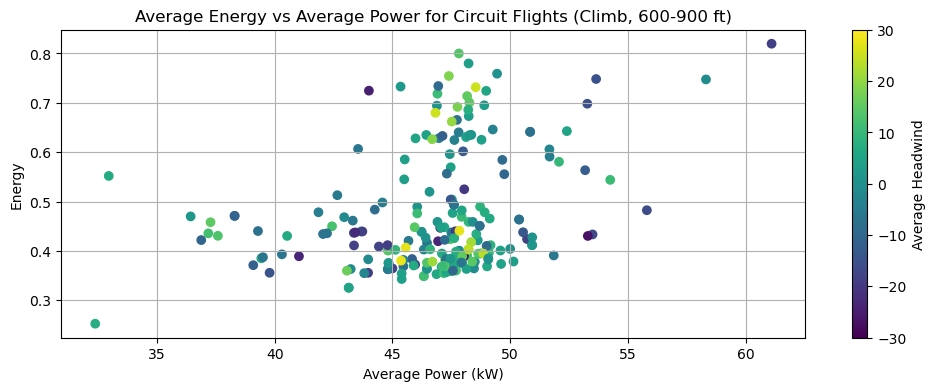

C:\Users\Nathan\AppData\Local\Temp\ipykernel_14672\2375036572.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Power Bin'] = pd.cut(filtered_df['Avg Power'], bins)


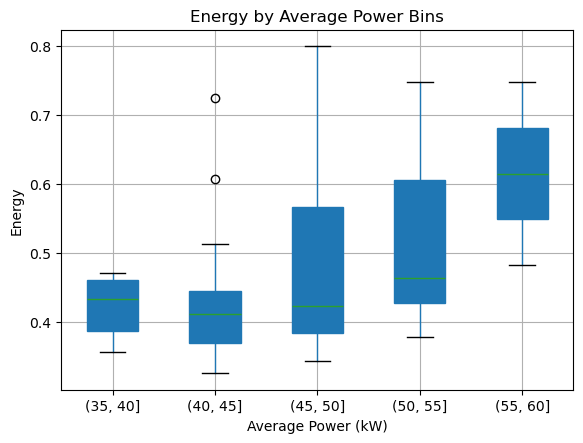

Box Plot Summary Statistics:
           count      mean       std       min       25%       50%       75%  \
Power Bin                                                                      
(35, 40]    12.0  0.424730  0.040949  0.355666  0.386638  0.433006  0.461003   
(40, 45]    35.0  0.424562  0.077933  0.325382  0.369976  0.411024  0.444640   
(45, 50]   142.0  0.477670  0.123612  0.343031  0.383169  0.422972  0.566169   
(50, 55]    21.0  0.520384  0.112531  0.378536  0.427523  0.463554  0.605648   
(55, 60]     2.0  0.614833  0.187333  0.482369  0.548601  0.614833  0.681066   

                max  
Power Bin            
(35, 40]   0.470917  
(40, 45]   0.724511  
(45, 50]   0.799851  
(50, 55]   0.748150  
(55, 60]   0.747298  


C:\Users\Nathan\AppData\Local\Temp\ipykernel_14672\2375036572.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = filtered_df.groupby('Power Bin')['Energy'].describe()


Avg Power  Energy/km  Adjusted Energy/km  Avg Headwind   Time/ft  \
0    53.500000   0.447079            0.517435    -16.336077  0.000032   
1    55.806452   0.390579            0.443123    -16.145771  0.000050   
2    50.716667   0.375588            0.438906    -18.778675  0.000031   
3    61.104167   0.458273            0.535736    -18.824653  0.000026   
4    50.548387   0.352096            0.390964    -13.753422  0.000031   
..         ...        ...                 ...           ...       ...   
213  48.347826   0.154386            0.153778      0.915559  0.000024   
214  48.270833   0.158788            0.157740      1.803991  0.000022   
215  48.705882   0.198607            0.204801     -7.356380 -0.001413   
216  50.847826   0.193893            0.199599     -7.528050  0.000026   
217  47.611111   0.191790            0.197464     -7.070286  0.000040   

       Energy  Distance  Average OAT   SoH    Stage     Power Bin  
0    0.433364  0.991210    20.000000  97.0  takeoff  (50.0, 55.0]  
1    0.482369  1.243731    20.000000  97.0  takeoff  (55.0, 60.0]  
2    0.423990  1.157073    20.000000  97.0  takeoff  (50.0, 55.0]  
3    0.819606  1.802662    20.000000  97.0  takeoff           NaN  
4    0.437800  1.245118    20.000000  97.0  takeoff  (50.0, 55.0]  
..        ...       ...          ...   ...      ...           ...  
213  0.635022  2.053608    18.489130  74.0  takeoff  (45.0, 50.0]  
214  0.634372  2.040431    18.083333  74.0  takeoff  (45.0, 50.0]  
215  0.450741  1.172839    24.985294  71.0  takeoff  (45.0, 50.0]  
216  0.641145  1.699160    23.869565  71.0  takeoff  (50.0, 55.0]  
217  0.493676  1.251517    23.500000  71.0  takeoff  (45.0, 50.0]  

[215 rows x 11 columns]

In [10]:
def stage_three_takeoff():
    
    plt.figure(figsize=(12, 4))

    df_slope = pd.DataFrame(columns=['Avg Power', 'Energy/km', 'Adjusted Energy/km', 'Avg Headwind', 'Time/ft','Energy', 'Distance', 'Average OAT','SoH',"Stage"])
    
    file_iterate(df_slope, "takeoff", min_alt=600, max_alt=900)
                    
    print('')
    print("Plotting...")
    
    filtered_df = df_slope
    filtered_df = filtered_df[(filtered_df['Energy'] < 1) & (filtered_df['Energy/km'] > 0.05)]
    
    print(len(filtered_df))
    colors = plt.cm.viridis(np.linspace(0, 1, len(filtered_df)))
    custom_colormap = mcolors.ListedColormap(colors)
    norm = mcolors.Normalize(vmin=-30, vmax=30)
    plt.scatter(
    filtered_df["Avg Power"], 
    filtered_df["Energy"],
    marker='o', 
    c=filtered_df["Avg Headwind"], 
    cmap=custom_colormap, 
    norm=norm
)

    plt.colorbar(label='Average Headwind', cmap=custom_colormap, norm=norm)
    plt.xlabel('Average Power (kW)')
    plt.ylabel('Energy')
    plt.title('Average Energy vs Average Power for Circuit Flights (Climb, 600-900 ft)')
    plt.grid(True)
    plt.show()
    
    
    # Box Plots
    bins = np.arange(35, 65, 5)
    filtered_df['Power Bin'] = pd.cut(filtered_df['Avg Power'], bins)

    filtered_df.boxplot(column='Energy', by='Power Bin', grid=False, patch_artist=True)

    plt.xlabel('Average Power (kW)')
    plt.ylabel('Energy')
    plt.title('Energy by Average Power Bins')
    plt.suptitle('')
    plt.grid(True)
    plt.show()
    summary = filtered_df.groupby('Power Bin')['Energy'].describe()
    print("Box Plot Summary Statistics:")
    print(summary)
    
    return filtered_df
    
    

stage_three_takeoff()


#### Main Stages

Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-26897-6263_2024jun03_0920pm_dc [100%]
Plotting...
288


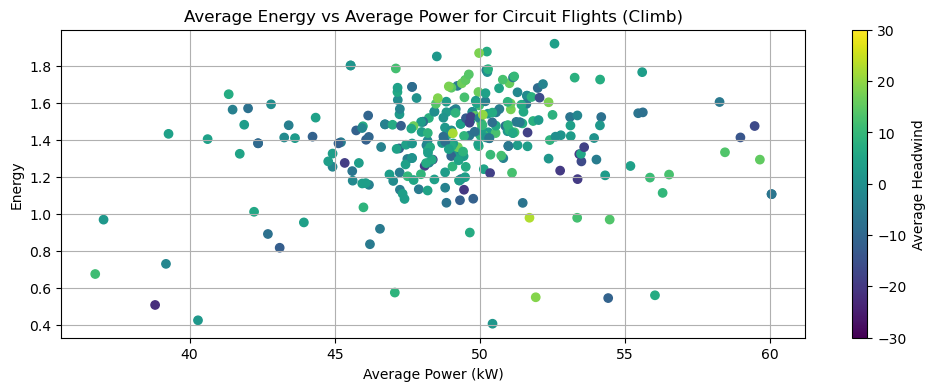

C:\Users\Nathan\AppData\Local\Temp\ipykernel_14672\3525077357.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Power Bin'] = pd.cut(filtered_df['Avg Power'], bins)


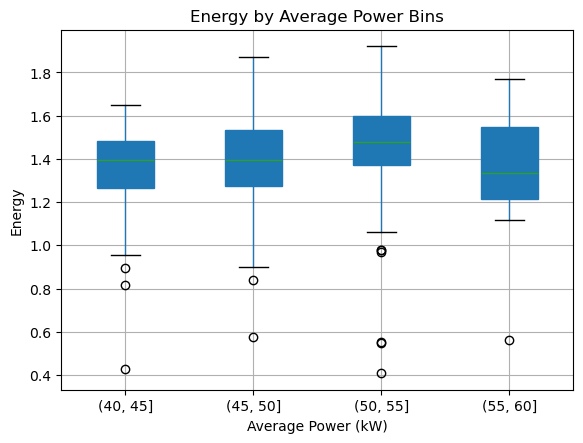

Box Plot Summary Statistics:
           count      mean       std       min       25%       50%       75%  \
Power Bin                                                                      
(40, 45]    22.0  1.299674  0.300713  0.426508  1.263916  1.394904  1.483216   
(45, 50]   145.0  1.399674  0.209507  0.576454  1.276450  1.397284  1.533660   
(50, 55]   101.0  1.451805  0.243724  0.407963  1.373091  1.479779  1.596418   
(55, 60]    13.0  1.334226  0.298018  0.561756  1.214480  1.334907  1.546209   

                max  
Power Bin            
(40, 45]   1.648995  
(45, 50]   1.871466  
(50, 55]   1.921957  
(55, 60]   1.768199  
     Avg Power  Energy/km  Adjusted Energy/km  Avg Headwind   Time/ft  \
0    51.991379   0.411578            0.444847     -9.118844  0.000061   
1    53.494186   0.370833            0.415837    -16.543638  0.000012   
2    51.128713   0.376945            0.427795    -16.757280  0.000031   
3    59.460674   0.427982            0.484691    -16.259629  0.000

C:\Users\Nathan\AppData\Local\Temp\ipykernel_14672\3525077357.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = filtered_df.groupby('Power Bin')['Energy'].describe()


In [11]:
def takeoff_pts(output = False):
    
    plt.figure(figsize=(12, 4))

    df_slope = pd.DataFrame(columns=['Avg Power', 'Energy/km', 'Adjusted Energy/km', 'Avg Headwind', 'Time/ft','Energy', 'Distance', 'Average OAT','SoH',"Stage"])
    
    file_iterate(df_slope, "takeoff")
    
    filtered_df = df_slope
    filtered_df = filtered_df[(filtered_df['Energy'] < 3) & (filtered_df['Energy/km'] > 0.05)]
    if output:               
        print('')
        print("Plotting...")
        
        print(len(filtered_df))
        colors = plt.cm.viridis(np.linspace(0, 1, len(filtered_df)))
        custom_colormap = mcolors.ListedColormap(colors)
        norm = mcolors.Normalize(vmin=-30, vmax=30)
        plt.scatter(
        filtered_df["Avg Power"], 
        filtered_df["Energy"],
        marker='o', 
        c=filtered_df["Avg Headwind"], 
        cmap=custom_colormap, 
        norm=norm
    )

        plt.colorbar(label='Average Headwind', cmap=custom_colormap, norm=norm)
        plt.xlabel('Average Power (kW)')
        plt.ylabel('Energy')
        plt.title('Average Energy vs Average Power for Circuit Flights (Climb)')
        plt.grid(True)
        plt.show()
        
        
        # Box Plots
        bins = np.arange(40, 65, 5)
        filtered_df['Power Bin'] = pd.cut(filtered_df['Avg Power'], bins)

        filtered_df.boxplot(column='Energy', by='Power Bin', grid=False, patch_artist=True)

        plt.xlabel('Average Power (kW)')
        plt.ylabel('Energy')
        plt.title('Energy by Average Power Bins')
        plt.suptitle('')
        plt.grid(True)
        plt.show()
        summary = filtered_df.groupby('Power Bin')['Energy'].describe()
        print("Box Plot Summary Statistics:")
        print(summary)
        
    return filtered_df
    
    

print(takeoff_pts(True))


Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-26897-6263_2024jun03_0920pm_dc [100%]
Plotting...
291


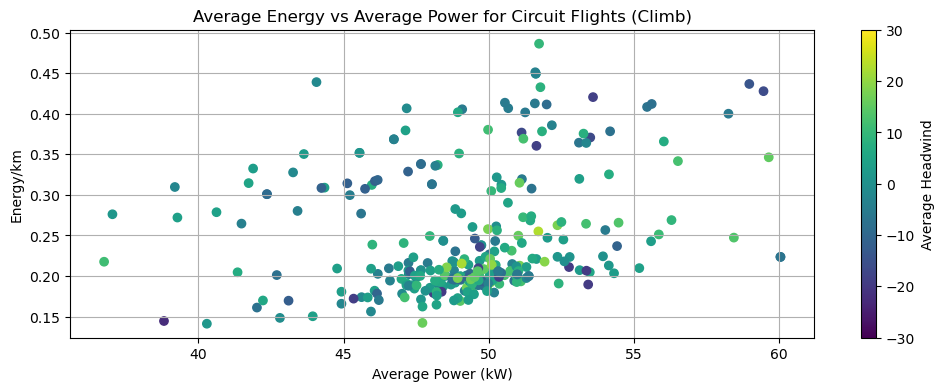

C:\Users\Nathan\AppData\Local\Temp\ipykernel_14672\1279602711.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Power Bin'] = pd.cut(filtered_df['Avg Power'], bins)


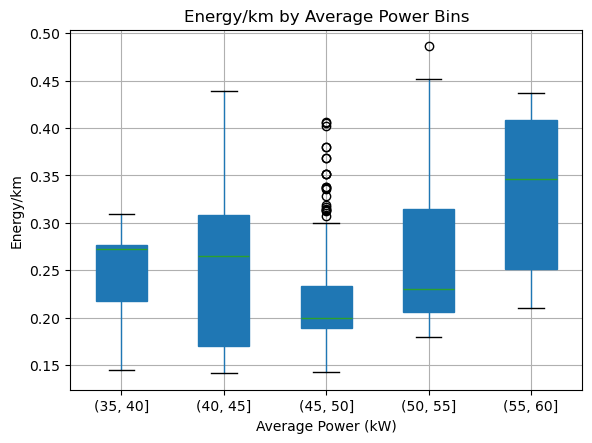

Box Plot Summary Statistics:
           count      mean       std       min       25%       50%       75%  \
Power Bin                                                                      
(35, 40]     5.0  0.243999  0.064725  0.144443  0.217568  0.272089  0.276124   
(40, 45]    23.0  0.248194  0.081983  0.141097  0.169641  0.264594  0.308760   
(45, 50]   147.0  0.222853  0.058751  0.142120  0.188537  0.199486  0.233133   
(50, 55]   101.0  0.266697  0.079717  0.179522  0.205791  0.230324  0.314962   
(55, 60]    13.0  0.335369  0.081151  0.209695  0.251249  0.346406  0.408519   

                max  
Power Bin            
(35, 40]   0.309772  
(40, 45]   0.439154  
(45, 50]   0.406791  
(50, 55]   0.486512  
(55, 60]   0.436864  


C:\Users\Nathan\AppData\Local\Temp\ipykernel_14672\1279602711.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = filtered_df.groupby('Power Bin')['Energy/km'].describe()


Avg Power  Energy/km  Adjusted Energy/km  Avg Headwind   Time/ft  \
0    51.991379   0.411578            0.444847     -9.118844  0.000061   
1    53.494186   0.370833            0.415837    -16.543638  0.000012   
2    51.128713   0.376945            0.427795    -16.757280  0.000031   
3    59.460674   0.427982            0.484691    -16.259629  0.000015   
4    58.970930   0.436864            0.485739    -13.948731 -0.000004   
..         ...        ...                 ...           ...       ...   
288  48.197674   0.164530            0.161641      4.666649  0.000029   
289  50.323529   0.205791            0.211198     -6.054270 -0.000444   
290  50.979167   0.201868            0.206884     -5.889723  0.000037   
291  60.044118   0.223507            0.229450     -6.798712  0.000022   
292  51.375000   0.199882            0.204728     -5.620397  0.000033   

       Energy  Distance  Average OAT   SoH    Stage     Power Bin  
0    1.682686  4.169675    19.834052  97.0  takeoff  (50.0, 55.0]  
1    1.285628  3.494469    20.000000  97.0  takeoff  (50.0, 55.0]  
2    1.440040  3.881798    19.923267  97.0  takeoff  (50.0, 55.0]  
3    1.476959  3.489884    19.918539  97.0  takeoff  (55.0, 60.0]  
4    1.415253  3.277296    19.915698  97.0  takeoff  (55.0, 60.0]  
..        ...       ...          ...   ...      ...           ...  
288  1.128299  3.557224    18.209302  74.0  takeoff  (45.0, 50.0]  
289  1.410929  3.514854    25.612745  71.0  takeoff  (50.0, 55.0]  
290  1.369073  3.425913    24.026042  71.0  takeoff  (50.0, 55.0]  
291  1.108687  2.562054    23.808824  71.0  takeoff           NaN  
292  1.496692  3.792626    23.562500  71.0  takeoff  (50.0, 55.0]  

[291 rows x 11 columns]

In [12]:
def takeoff_pts(output = False):
    
    plt.figure(figsize=(12, 4))

    df_slope = pd.DataFrame(columns=['Avg Power', 'Energy/km', 'Adjusted Energy/km', 'Avg Headwind', 'Time/ft','Energy', 'Distance', 'Average OAT','SoH',"Stage"])
    
    file_iterate(df_slope, "takeoff")
    
    filtered_df = df_slope
    filtered_df = filtered_df[(filtered_df['Energy/km'] < 1) & (filtered_df['Energy/km'] > 0.05)]
    if output:               
        print('')
        print("Plotting...")
        
        
        
        print(len(filtered_df))
        colors = plt.cm.viridis(np.linspace(0, 1, len(filtered_df)))
        custom_colormap = mcolors.ListedColormap(colors)
        norm = mcolors.Normalize(vmin=-30, vmax=30)
        plt.scatter(
        filtered_df["Avg Power"], 
        filtered_df["Energy/km"],
        marker='o', 
        c=filtered_df["Avg Headwind"], 
        cmap=custom_colormap, 
        norm=norm
    )

        plt.colorbar(label='Average Headwind', cmap=custom_colormap, norm=norm)
        plt.xlabel('Average Power (kW)')
        plt.ylabel('Energy/km')
        plt.title('Average Energy vs Average Power for Circuit Flights (Climb)')
        plt.grid(True)
        plt.show()
        
        
        # Box Plots
        bins = np.arange(35, 65, 5)
        filtered_df['Power Bin'] = pd.cut(filtered_df['Avg Power'], bins)

        filtered_df.boxplot(column='Energy/km', by='Power Bin', grid=False, patch_artist=True)

        plt.xlabel('Average Power (kW)')
        plt.ylabel('Energy/km')
        plt.title('Energy/km by Average Power Bins')
        plt.suptitle('')
        plt.grid(True)
        plt.show()
        summary = filtered_df.groupby('Power Bin')['Energy/km'].describe()
        print("Box Plot Summary Statistics:")
        print(summary)
        
    return filtered_df
    
    

takeoff_pts(True)


Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-26897-6263_2024jun03_0920pm_dc [100%]
Plotting...
273


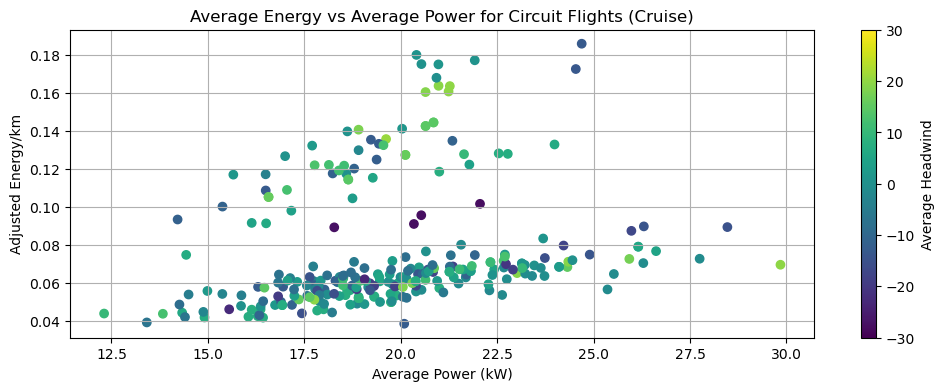

C:\Users\Nathan\AppData\Local\Temp\ipykernel_14672\1807959445.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Power Bin'] = pd.cut(filtered_df['Avg Power'], bins)


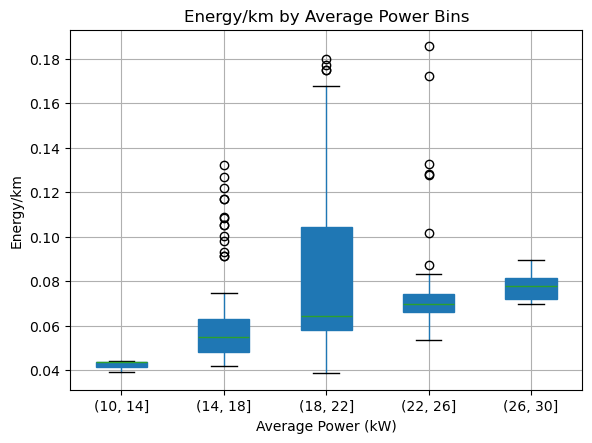

Box Plot Summary Statistics:
           count      mean       std       min       25%       50%       75%  \
Power Bin                                                                      
(10, 14]     3.0  0.042369  0.002664  0.039294  0.041569  0.043845  0.043907   
(14, 18]    70.0  0.063897  0.024006  0.041824  0.048405  0.054902  0.063019   
(18, 22]   149.0  0.080944  0.035636  0.038619  0.058193  0.064454  0.104487   
(22, 26]    43.0  0.078897  0.028391  0.053724  0.066128  0.069894  0.074426   
(26, 30]     8.0  0.078367  0.007796  0.069606  0.072190  0.077927  0.081667   

                max  
Power Bin            
(10, 14]   0.043969  
(14, 18]   0.132194  
(18, 22]   0.179849  
(22, 26]   0.185728  
(26, 30]   0.089757  


C:\Users\Nathan\AppData\Local\Temp\ipykernel_14672\1807959445.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = filtered_df.groupby('Power Bin')['Adjusted Energy/km'].describe()


Avg Power  Energy/km  Adjusted Energy/km  Avg Headwind   Time/ft  \
0    19.620690   0.158284            0.135636     20.648771  0.000082   
1    21.273196   0.192883            0.163465     19.753558 -0.001204   
2    21.240566   0.188343            0.160611     19.815539 -0.000099   
3    20.643678   0.188007            0.160323     18.982040 -0.000038   
4    18.906977   0.161405            0.140569     17.979540  0.000392   
..         ...        ...                 ...           ...       ...   
272  20.125000   0.071401            0.073618     -8.563229  0.002341   
273  20.387097   0.062307            0.060998      6.990177  0.000309   
274  21.263158   0.067358            0.065908      6.980714 -0.000046   
275  26.157895   0.080473            0.079092      5.746649 -0.000068   
276  16.928571   0.049356            0.048392      7.071830 -0.000058   

       Energy  Distance  Average OAT   SoH   Stage Power Bin  
0    0.318220  1.970989    19.599138  97.0  cruise  (18, 22]  
1    0.575588  3.006507    19.682990  97.0  cruise  (18, 22]  
2    0.628771  3.343225    19.667453  97.0  cruise  (18, 22]  
3    0.502071  2.670637    19.663793  97.0  cruise  (18, 22]  
4    0.454303  2.817700    19.561047  97.0  cruise  (18, 22]  
..        ...       ...          ...   ...     ...       ...  
272  0.488775  3.476778    17.392045  74.0  cruise  (18, 22]  
273  0.348190  2.839988    24.153226  71.0  cruise  (18, 22]  
274  0.226572  1.681023    23.500000  71.0  cruise  (18, 22]  
275  0.278844  1.756780    23.000000  71.0  cruise  (26, 30]  
276  0.199136  1.946116    23.000000  71.0  cruise  (14, 18]  

[273 rows x 11 columns]

In [13]:
def cruise_pts(output = False):
    
    plt.figure(figsize=(12, 4))

    df_slope = pd.DataFrame(columns=['Avg Power', 'Energy/km', 'Adjusted Energy/km', 'Avg Headwind', 'Time/ft','Energy', 'Distance', 'Average OAT','SoH',"Stage"])
    
    file_iterate(df_slope, "cruise")
    
    
    
    filtered_df = df_slope
    filtered_df = filtered_df[(filtered_df['Energy/km'] < 1) & (filtered_df['Avg Power'] > 10)& (filtered_df['Avg Power'] < 30)]
    
    if output:
    
        
        print('')
        print("Plotting...")
        print(len(filtered_df))
        colors = plt.cm.viridis(np.linspace(0, 1, len(filtered_df)))
        custom_colormap = mcolors.ListedColormap(colors)
        norm = mcolors.Normalize(vmin=-30, vmax=30)
        plt.scatter(
        filtered_df["Avg Power"], 
        filtered_df["Adjusted Energy/km"],
        marker='o', 
        c=filtered_df["Avg Headwind"], 
        cmap=custom_colormap, 
        norm=norm
    )

        plt.colorbar(label='Average Headwind', cmap=custom_colormap, norm=norm)
        plt.xlabel('Average Power (kW)')
        plt.ylabel('Adjusted Energy/km')
        plt.title('Average Energy vs Average Power for Circuit Flights (Cruise)')
        plt.grid(True)
        plt.show()
        
        
        # Box Plots
        bins = np.arange(10, 34, 4)
        filtered_df['Power Bin'] = pd.cut(filtered_df['Avg Power'], bins)

        filtered_df.boxplot(column='Adjusted Energy/km', by='Power Bin', grid=False, patch_artist=True)

        plt.xlabel('Average Power (kW)')
        plt.ylabel('Energy/km')
        plt.title('Energy/km by Average Power Bins')
        plt.suptitle('')
        plt.grid(True)
        plt.show()
        summary = filtered_df.groupby('Power Bin')['Adjusted Energy/km'].describe()
        print("Box Plot Summary Statistics:")
        print(summary)
    
    return filtered_df
    
    

cruise_pts(True)


Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-26897-6263_2024jun03_0920pm_dc [100%]
Plotting...
259


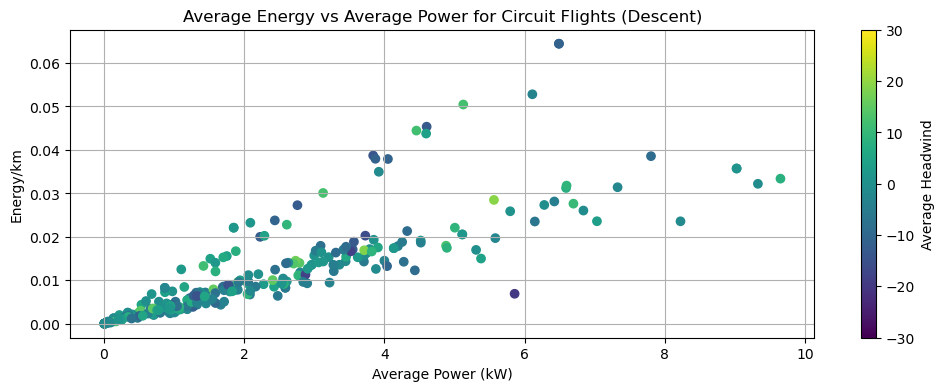

C:\Users\Nathan\AppData\Local\Temp\ipykernel_14672\274519535.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Power Bin'] = pd.cut(filtered_df['Avg Power'], bins)


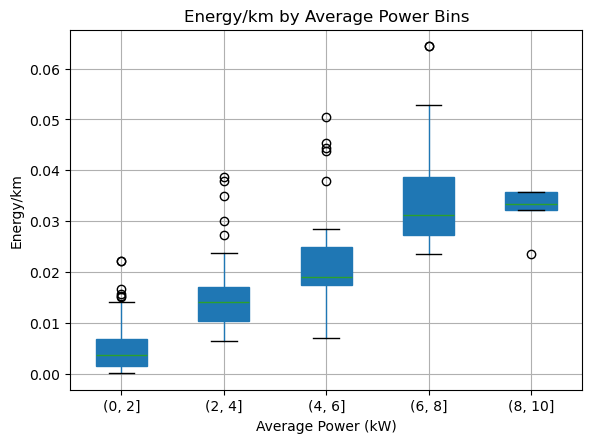

Box Plot Summary Statistics:
           count      mean       std       min       25%       50%       75%  \
Power Bin                                                                      
(0, 2]     140.0  0.004597  0.004230  0.000031  0.001577  0.003635  0.006880   
(2, 4]      75.0  0.015023  0.006533  0.006436  0.010245  0.014059  0.016998   
(4, 6]      26.0  0.023245  0.011435  0.006920  0.017411  0.019004  0.024953   
(6, 8]      13.0  0.036238  0.014664  0.023543  0.027349  0.031255  0.038576   
(8, 10]      5.0  0.032135  0.005015  0.023588  0.032213  0.033399  0.035739   

                max  
Power Bin            
(0, 2]     0.022117  
(2, 4]     0.038722  
(4, 6]     0.050455  
(6, 8]     0.064436  
(8, 10]    0.035739  


C:\Users\Nathan\AppData\Local\Temp\ipykernel_14672\274519535.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = filtered_df.groupby('Power Bin')['Energy/km'].describe()


Avg Power  Energy/km  Adjusted Energy/km  Avg Headwind   Time/ft  \
0     1.104167   0.012530            0.010171      2.299110 -0.000028   
1     0.136752   0.001262            0.001061      2.026847  0.000044   
2     0.221774   0.002034            0.001711      2.642625 -0.000209   
3     1.518248   0.014982            0.012466      4.126731 -0.000035   
4     0.681452   0.006855            0.005653      1.441576 -0.000516   
..         ...        ...                 ...           ...       ...   
266   0.783333   0.003153            0.003045      3.300592 -0.000041   
267   0.210526   0.001004            0.001037      1.247732 -0.000089   
268   4.134328   0.017411            0.017711      1.834603 -0.000619   
269   9.022472   0.035739            0.036169      0.941956 -0.000106   
270   5.111111   0.020571            0.020954      1.586199 -0.000130   

       Energy  Distance  Average OAT   SoH    Stage Power Bin  
0    0.029895  3.479276    19.500000  97.0  landing    (0, 2]  
1    0.004465  4.211849    19.523504  97.0  landing    (0, 2]  
2    0.007669  4.447765    19.500000  97.0  landing    (0, 2]  
3    0.058013  4.763769    19.500000  97.0  landing    (0, 2]  
4    0.023559  4.381957    19.500000  97.0  landing    (0, 2]  
..        ...       ...          ...   ...      ...       ...  
266  0.026004  3.783459    16.770833  74.0  landing    (0, 2]  
267  0.006647  3.922864    23.289474  71.0  landing    (0, 2]  
268  0.152570  4.785016    23.037313  71.0  landing    (4, 6]  
269  0.446324  6.515347    22.814607  71.0  landing   (8, 10]  
270  0.205671  4.995435    22.395833  71.0  landing    (4, 6]  

[259 rows x 11 columns]

In [14]:
def landing_pts(output = False):
    
    plt.figure(figsize=(12, 4))

    df_slope = pd.DataFrame(columns=['Avg Power', 'Energy/km', 'Adjusted Energy/km', 'Avg Headwind', 'Time/ft','Energy', 'Distance', 'Average OAT','SoH',"Stage"])
    
    file_iterate(df_slope, "landing")
                    
    
    filtered_df = df_slope
    filtered_df = filtered_df[(filtered_df['Energy/km'] < 1) & (filtered_df['Avg Power'] < 10)]
    if output:
        print('')
        print("Plotting...")
        print(len(filtered_df))
        colors = plt.cm.viridis(np.linspace(0, 1, len(filtered_df)))
        custom_colormap = mcolors.ListedColormap(colors)
        norm = mcolors.Normalize(vmin=-30, vmax=30)
        plt.scatter(
        filtered_df["Avg Power"], 
        filtered_df["Energy/km"],
        marker='o', 
        c=filtered_df["Avg Headwind"], 
        cmap=custom_colormap, 
        norm=norm
    )

        plt.colorbar(label='Average Headwind', cmap=custom_colormap, norm=norm)
        plt.xlabel('Average Power (kW)')
        plt.ylabel('Energy/km')
        plt.title('Average Energy vs Average Power for Circuit Flights (Descent)')
        plt.grid(True)
        plt.show()
        
        
        # Box Plots
        bins = np.arange(0, 12, 2)
        filtered_df['Power Bin'] = pd.cut(filtered_df['Avg Power'], bins)

        filtered_df.boxplot(column='Energy/km', by='Power Bin', grid=False, patch_artist=True)

        plt.xlabel('Average Power (kW)')
        plt.ylabel('Energy/km')
        plt.title('Energy/km by Average Power Bins')
        plt.suptitle('')
        plt.grid(True)
        plt.show()
        summary = filtered_df.groupby('Power Bin')['Energy/km'].describe()
        print("Box Plot Summary Statistics:")
        print(summary)
        
    return filtered_df
    
    

landing_pts(True)


### 3D Modeling (not worth it as it takes more resources and efficiency plummets)

Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-26004-6243_2024may31_0516pm_dc [87%]
Plotting...


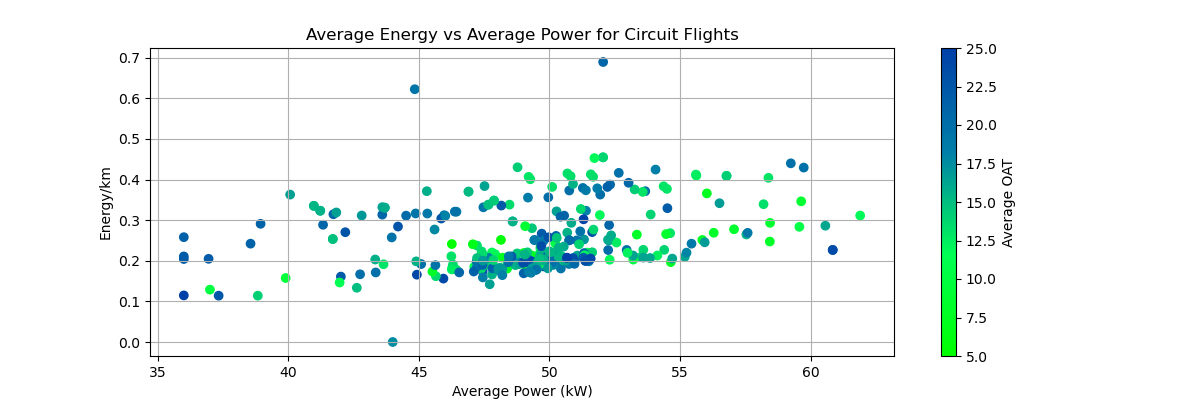

Plotting 3D scatter plot...


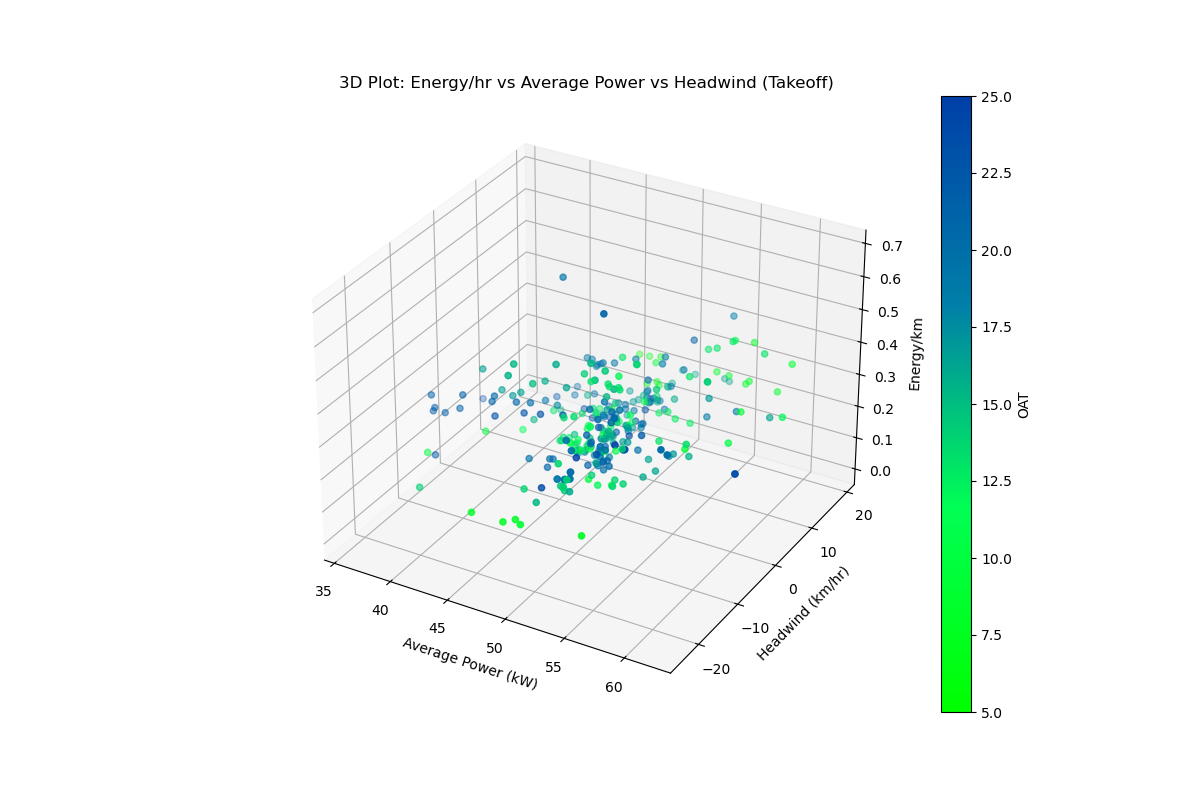

plotted


In [68]:
plt.close('all')    
def plot_3d(df_slope):
    print("Plotting 3D scatter plot...")
    
    colors = [(0, 1, 0), (0, 1, 0.33), (0, 0.5, 0.66), (0, 0.25, 0.66)]  # Green to Blue
    nodes = [0.0, 0.33, 0.66, 1.0]
    custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
    norm = mcolors.Normalize(vmin=5, vmax=25)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(
        df_slope["Avg Power"], 
        df_slope["Avg Headwind"],
        df_slope["Energy/km"],
        c=df_slope["Average OAT"],
        cmap=custom_colormap, 
        norm=norm
    )

    ax.set_xlabel('Average Power (kW)')
    ax.set_zlabel('Energy/km')
    ax.set_ylabel('Headwind (km/hr)')
    plt.title('3D Plot: Energy/hr vs Average Power vs Headwind (Takeoff)')
    plt.colorbar(sc, label='OAT')
    
    plt.show()
    print("plotted")

df_slope = takeoff_pts()
plot_3d(df_slope)


Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-26004-6243_2024may31_0516pm_dc [87%]
Plotting...


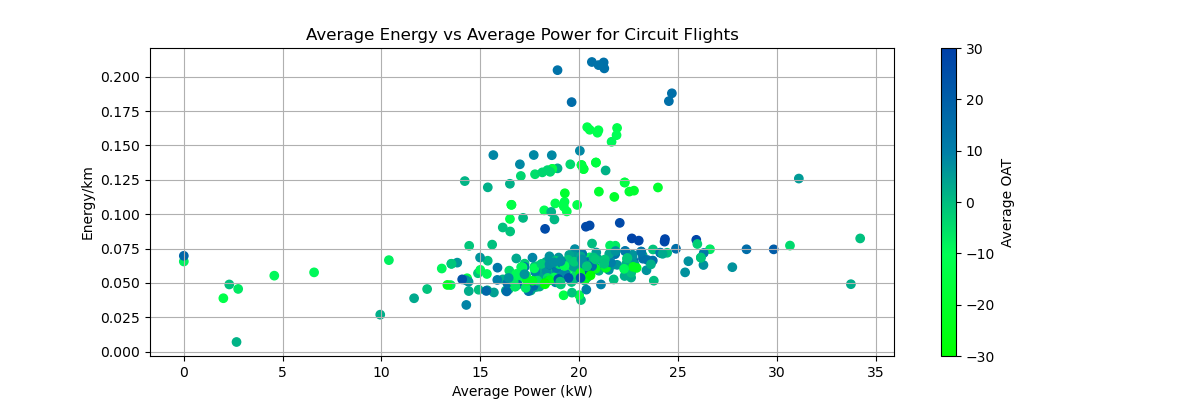

Plotting 3D scatter plot...


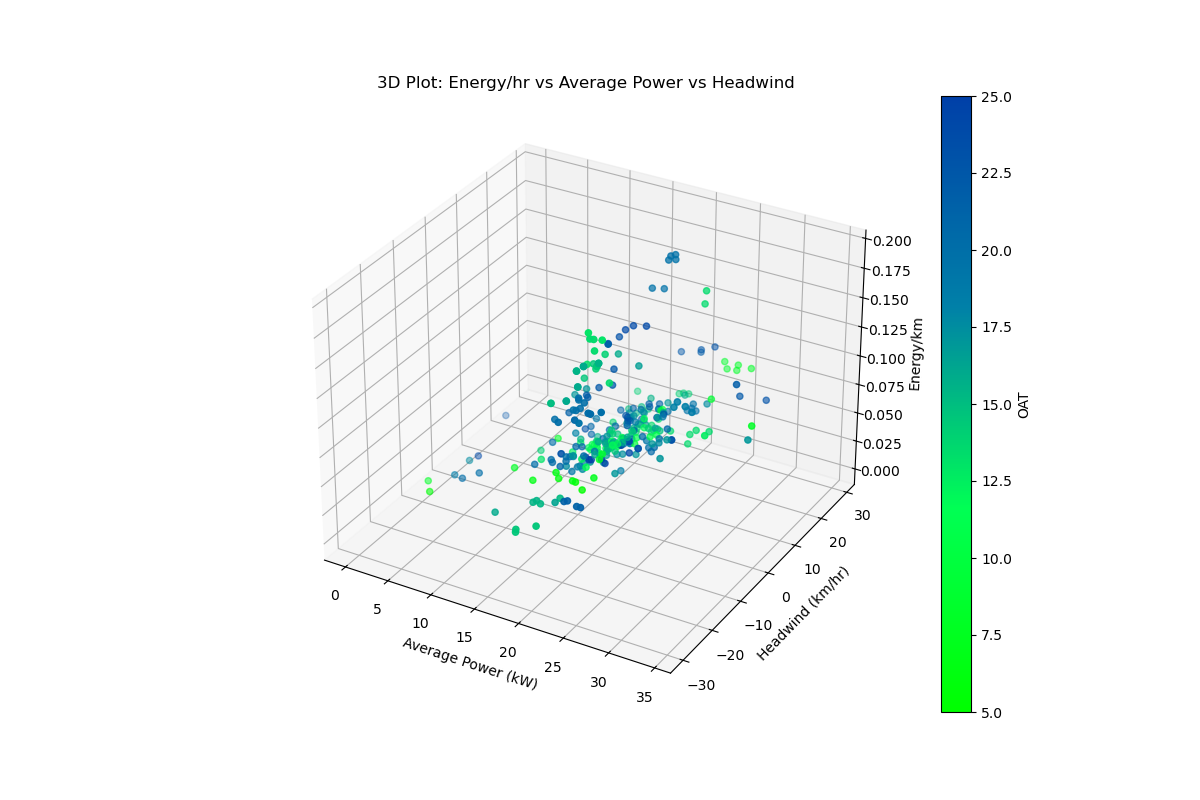

plotted


In [38]:
def plot_3d(df_slope):
    print("Plotting 3D scatter plot...")
    
    colors = [(0, 1, 0), (0, 1, 0.33), (0, 0.5, 0.66), (0, 0.25, 0.66)]  # Green to Blue
    nodes = [0.0, 0.33, 0.66, 1.0]
    custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
    norm = mcolors.Normalize(vmin=5, vmax=25)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(
        df_slope["Avg Power"], 
        df_slope["Avg Headwind"], 
        df_slope["Energy/km"],
        c=df_slope["Average OAT"], 
        cmap=custom_colormap, 
        norm=norm
    )

    ax.set_xlabel('Average Power (kW)')
    ax.set_zlabel('Energy/km')
    ax.set_ylabel('Headwind (km/hr)')
    plt.title('3D Plot: Energy/hr vs Average Power vs Headwind')
    plt.colorbar(sc, label='OAT')
    
    plt.show()
    print("plotted")

df_slope = cruise_pts()
plot_3d(df_slope)


Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-26004-6243_2024may31_0516pm_dc [87%]
Plotting...


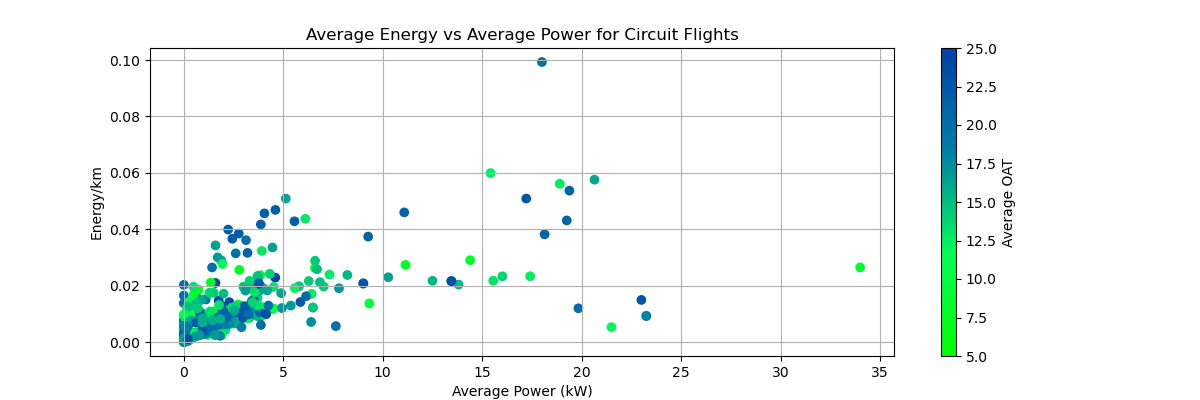

Plotting 3D scatter plot...


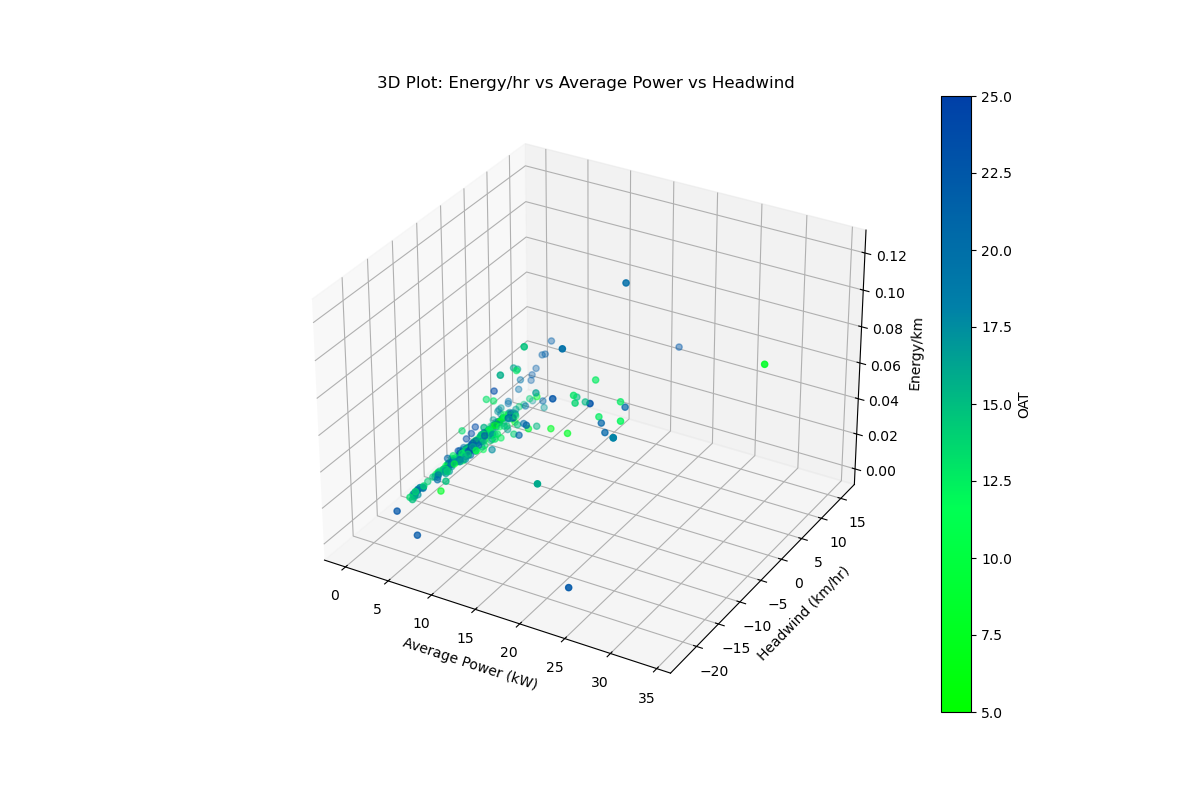

plotted


In [70]:
def plot_3d(df_slope):
    print("Plotting 3D scatter plot...")
    
    colors = [(0, 1, 0), (0, 1, 0.33), (0, 0.5, 0.66), (0, 0.25, 0.66)]  # Green to Blue
    nodes = [0.0, 0.33, 0.66, 1.0]
    custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
    norm = mcolors.Normalize(vmin=5, vmax=25)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(
        df_slope["Avg Power"], 
        df_slope["Avg Headwind"], 
        df_slope["Energy/km"],
        c=df_slope["Average OAT"], 
        cmap=custom_colormap, 
        norm=norm
    )

    ax.set_xlabel('Average Power (kW)')
    ax.set_zlabel('Energy/km')
    ax.set_ylabel('Headwind (km/hr)')
    plt.title('3D Plot: Energy/hr vs Average Power vs Headwind')
    plt.colorbar(sc, label='OAT')
    
    plt.show()
    print("plotted")

df_slope = landing_pts()
plot_3d(df_slope)


### PCA

In [32]:
def plot_2d_pca(df_slope):
    print("Applying PCA and plotting 2D scatter plot...")

    features = ["Avg Power", "Avg Headwind", "Energy/km","Average OAT","SoH"]
    x = df_slope[features]
    
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(x)

    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    

    # 2d plot
    plt.figure(figsize=(12, 8))
    sc = plt.scatter(
        pca_df["PC1"], 
        pca_df["PC2"], 
    )

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('2D PCA Plot')
    
    plt.show()
    print("Plotted PCA in 2D")

Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-26897-6263_2024jun03_0920pm_dc [100%]Applying PCA and plotting 2D scatter plot...


<Figure size 1200x400 with 0 Axes>

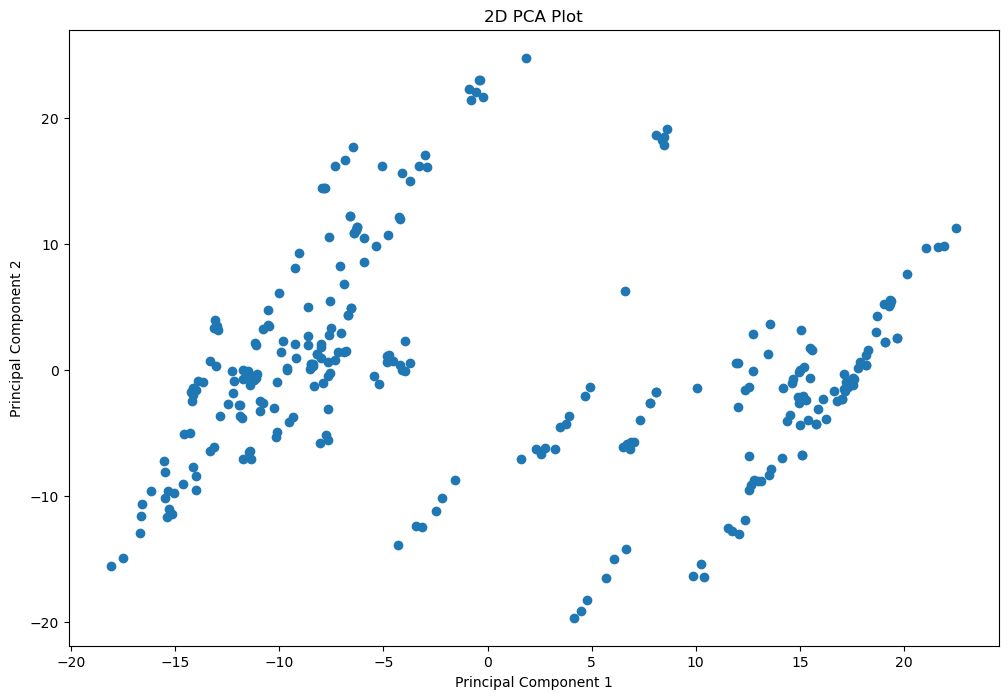

Plotted PCA in 2D


In [34]:
plot_2d_pca(takeoff_pts())

Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-26897-6263_2024jun03_0920pm_dc [100%]Applying PCA and plotting 2D scatter plot...


<Figure size 1200x400 with 0 Axes>

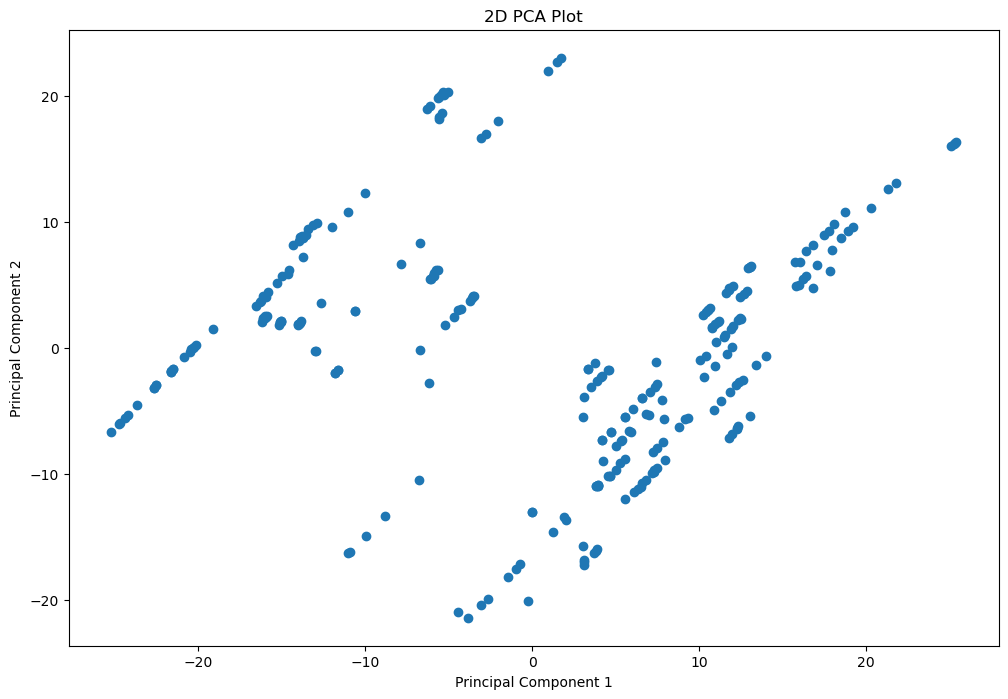

Plotted PCA in 2D


In [35]:
plot_2d_pca(cruise_pts() )

Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-26897-6263_2024jun03_0920pm_dc [100%]Applying PCA and plotting 2D scatter plot...


<Figure size 1200x400 with 0 Axes>

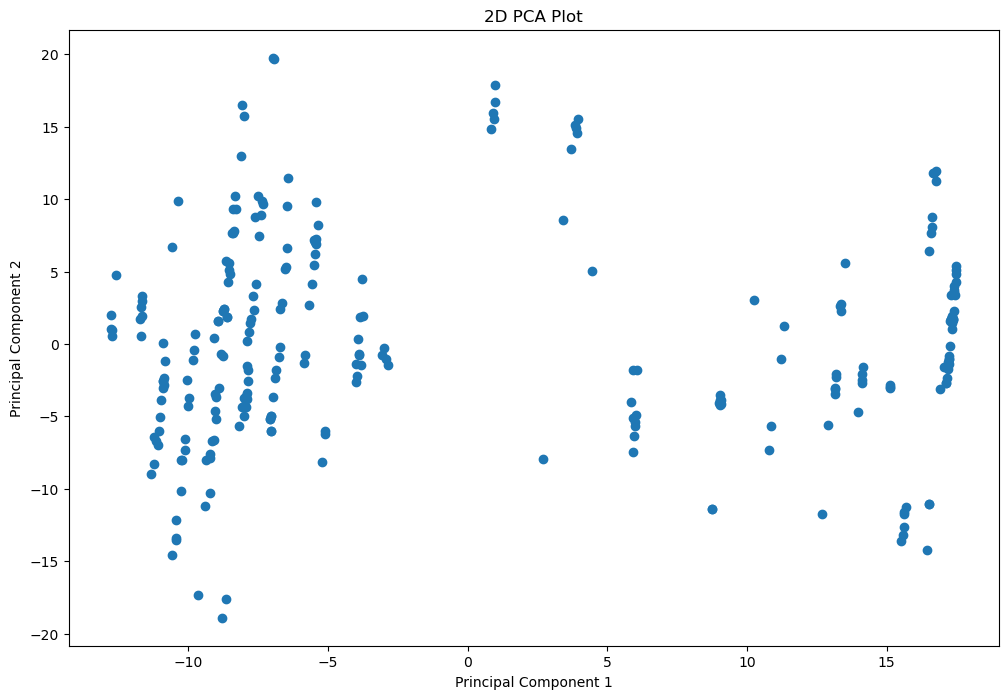

Plotted PCA in 2D


In [36]:
plot_2d_pca(landing_pts())


### Feature Contribution

In [37]:
def calculate_feature_importance(df_slope):
    print("Training Random Forest and displaying feature importance...")

    features = ["Avg Power", "Avg Headwind", "Average OAT"]
    x = df_slope[features]
    y = df_slope['Energy/km']  

    
    x_scaled = StandardScaler().fit_transform(x)

    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(x_scaled, y)

    
    importances = rf.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Feature Importance from Random Forest')
    plt.gca().invert_yaxis()
    plt.show()

    print("Displayed feature importance")

plt.close('all')




Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-26897-6263_2024jun03_0920pm_dc [100%]Training Random Forest and displaying feature importance...


<Figure size 1200x400 with 0 Axes>

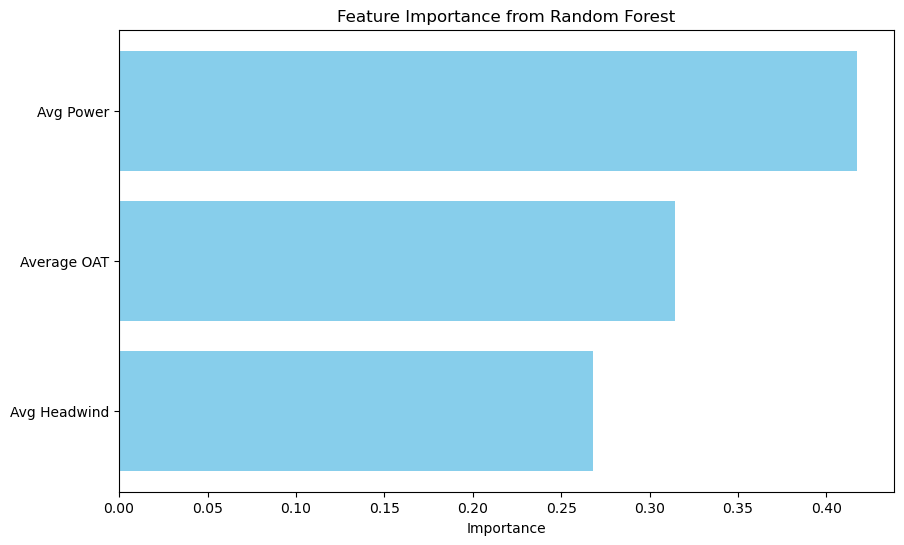

Displayed feature importance


In [38]:
calculate_feature_importance(takeoff_pts())

Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-26897-6263_2024jun03_0920pm_dc [100%]Training Random Forest and displaying feature importance...


<Figure size 1200x400 with 0 Axes>

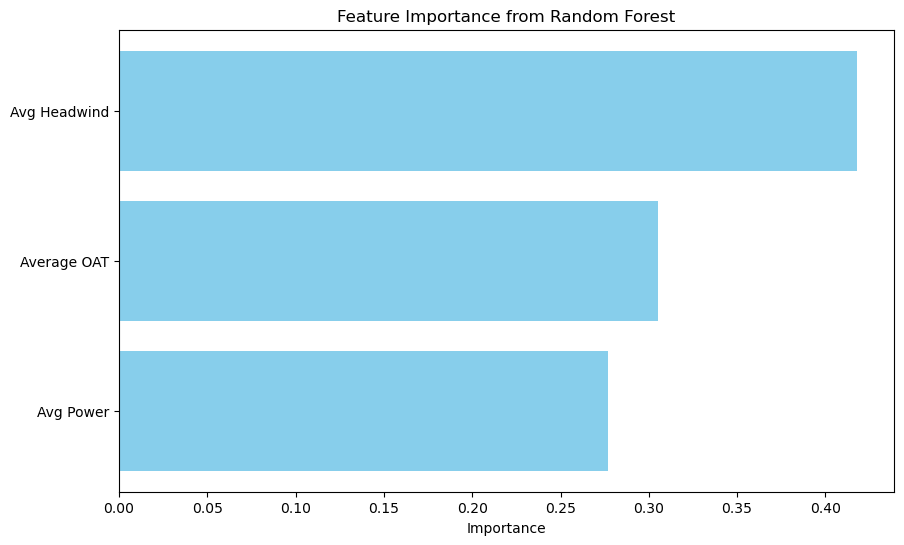

Displayed feature importance


In [39]:
calculate_feature_importance(cruise_pts())

Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-26897-6263_2024jun03_0920pm_dc [100%]Training Random Forest and displaying feature importance...


<Figure size 1200x400 with 0 Axes>

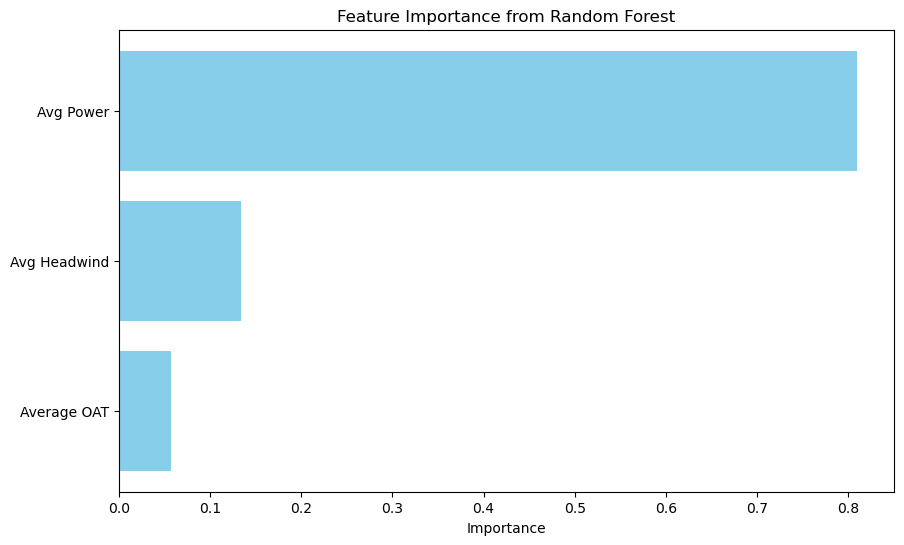

Displayed feature importance


In [40]:
calculate_feature_importance(landing_pts())

### XGBoost Regressor (Energy per Km)

In [50]:
#Decision Tree Regressor

# def predict_energy_km(df_slope, stage):
#     if stage == 'takeoff':
#         stage_num = 0
#     elif stage == 'cruise':
#         stage_num = 1
#     elif stage == 'landing':
#         stage_num = 2
#     df_stage = df_slope.copy()
#     X = df_stage[['SoH', 'Average OAT', 'Avg Power','Avg Headwind']]
#     y_energy_km = df_stage['Energy/km']


#     X_train, X_test, y_train_energy_km, y_test_energy_km = train_test_split(
#         X, y_energy_km, test_size=0.25, random_state=42
#     )
    

#     model_energy_km = DecisionTreeRegressor(random_state=42)
#     model_energy_km.fit(X_train, y_train_energy_km)

#     pred_energy_km = model_energy_km.predict(X_test)

#     mse = mean_squared_error(y_test_energy_km, pred_energy_km)
#     print(f'Mean Squared Error for stage "{stage}": {mse}')
#     print(f'R-squared value for stage "{stage}": {model_energy_km.score(X_test, y_test_energy_km)}')

#     plt.figure(figsize=(12, 6))
#     plt.subplot(1, 2, 1)
#     plt.scatter(y_test_energy_km, pred_energy_km, alpha=0.5)
#     plt.plot([y_test_energy_km.min(), y_test_energy_km.max()],
#              [y_test_energy_km.min(), y_test_energy_km.max()],
#              'r--', lw=2)
#     plt.xlabel('Actual Energy/km')
#     plt.ylabel('Predicted Energy/km')
#     plt.title(f'Actual vs Predicted Energy/km ({stage.capitalize()})')
#     plt.grid(True)
    
#     plt.subplot(1, 2, 2)
#     plt.scatter(X_test['Avg Power'], y_test_energy_km, alpha=0.5, label='Actual')
#     plt.scatter(X_test['Avg Power'], pred_energy_km, alpha=0.5, label='Predicted')
#     plt.xlabel('Average Power (kW)')
#     plt.ylabel('Energy/km')
#     plt.title(f'Energy/km vs Average Power ({stage.capitalize()})')
#     plt.legend()
#     plt.grid(True)

#     plt.tight_layout()
#     plt.show()


In [243]:
# RF Regressor

# def predict_energy_km(df_slope, stage):
#     if stage == 'takeoff':
#         stage_num = 0
#     elif stage == 'cruise':
#         stage_num = 1
#     elif stage == 'landing':
#         stage_num = 2
#     df_stage = df_slope.copy()
#     X = df_stage[['SoH', 'Average OAT', 'Avg Power','Avg Headwind']]
#     y_energy_km = df_stage['Energy/km']

#     X_train, X_test, y_train_energy_km, y_test_energy_km = train_test_split(
#         X, y_energy_km, test_size=0.25, random_state=42
#     )
    
#     # Initialize and train the RandomForestRegressor
#     model_energy_km = RandomForestRegressor(n_estimators=100, random_state=42)
#     model_energy_km.fit(X_train, y_train_energy_km)

#     pred_energy_km = model_energy_km.predict(X_test)

#     mse = mean_squared_error(y_test_energy_km, pred_energy_km)
#     print(f'Mean Squared Error for stage "{stage}": {mse}')
#     print(f'R-squared value for stage "{stage}": {model_energy_km.score(X_test, y_test_energy_km)}')

#     plt.figure(figsize=(12, 6))
#     plt.subplot(1, 2, 1)
#     plt.scatter(y_test_energy_km, pred_energy_km, alpha=0.5)
#     plt.plot([y_test_energy_km.min(), y_test_energy_km.max()],
#              [y_test_energy_km.min(), y_test_energy_km.max()],
#              'r--', lw=2)
#     plt.xlabel('Actual Energy/km')
#     plt.ylabel('Predicted Energy/km')
#     plt.title(f'Actual vs Predicted Energy/km ({stage.capitalize()})')
#     plt.grid(True)
    
#     plt.subplot(1, 2, 2)
#     plt.scatter(X_test['Avg Power'], y_test_energy_km, alpha=0.5, label='Actual')
#     plt.scatter(X_test['Avg Power'], pred_energy_km, alpha=0.5, label='Predicted')
#     plt.xlabel('Average Power (kW)')
#     plt.ylabel('Energy/km')
#     plt.title(f'Energy/km vs Average Power ({stage.capitalize()})')
#     plt.legend()
#     plt.grid(True)

#     plt.tight_layout()
#     plt.show()


In [41]:
# XGBoost Regressor
def predict_energy_km(df_slope, stage):
    if stage == 'takeoff':
        stage_num = 0
    elif stage == 'cruise':
        stage_num = 1
    elif stage == 'landing':
        stage_num = 2

    df_stage = df_slope.copy()

    X = df_stage[['SoH', 'Average OAT', 'Avg Power', 'Avg Headwind']]
    y_energy_km = df_stage['Energy/km']

    X_train, X_test, y_train_energy_km, y_test_energy_km = train_test_split(
        X, y_energy_km, test_size=0.3, random_state=42
    )
    
    model_energy_km = XGBRegressor(random_state=42)
    model_energy_km.fit(X_train, y_train_energy_km)

    pred_energy_km = model_energy_km.predict(X_test)
    feature_names = X.columns
    feature_importances = model_energy_km.feature_importances_
    for feature_name, importance in zip(feature_names, feature_importances):
        print(f"{feature_name}: {importance}")

    mse = mean_squared_error(y_test_energy_km, pred_energy_km)
    print(f'Mean Squared Error for stage "{stage}": {mse}')
    print(f'R-squared value for stage "{stage}": {model_energy_km.score(X_test, y_test_energy_km)}')

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(y_test_energy_km, pred_energy_km, alpha=0.5)
    plt.plot([y_test_energy_km.min(), y_test_energy_km.max()],
             [y_test_energy_km.min(), y_test_energy_km.max()],
             'r--', lw=2)
    plt.xlabel('Actual Energy/km')
    plt.ylabel('Predicted Energy/km')
    plt.title(f'Actual vs Predicted Energy/km ({stage.capitalize()})')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.scatter(X_test['Avg Power'], y_test_energy_km, alpha=0.5, label='Actual')
    plt.scatter(X_test['Avg Power'], pred_energy_km, alpha=0.5, label='Predicted')
    plt.xlabel('Average Power (kW)')
    plt.ylabel('Energy/km')
    plt.title(f'Energy/km vs Average Power ({stage.capitalize()})')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-26897-6263_2024jun03_0920pm_dc [100%]SoH: 0.6485595107078552
Average OAT: 0.04555661231279373
Avg Power: 0.20046624541282654
Avg Headwind: 0.10541754215955734
Mean Squared Error for stage "takeoff": 0.001540561045505296
R-squared value for stage "takeoff": 0.7487793953896675


<Figure size 1200x400 with 0 Axes>

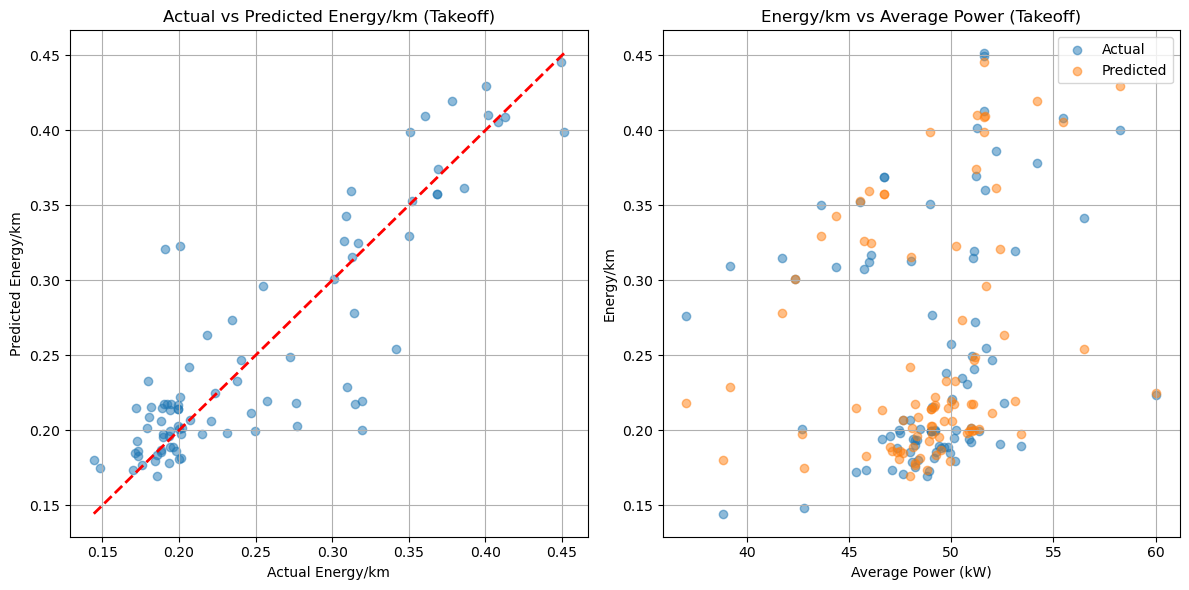

In [399]:
predict_energy_km(takeoff_pts(),"takeoff")

Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-26897-6263_2024jun03_0920pm_dc [100%]SoH: 0.9125028848648071
Average OAT: 0.0045037949457764626
Avg Power: 0.06999249756336212
Avg Headwind: 0.01300089806318283
Mean Squared Error for stage "cruise": 6.37058014790833e-05
R-squared value for stage "cruise": 0.9416504157427713


<Figure size 1200x400 with 0 Axes>

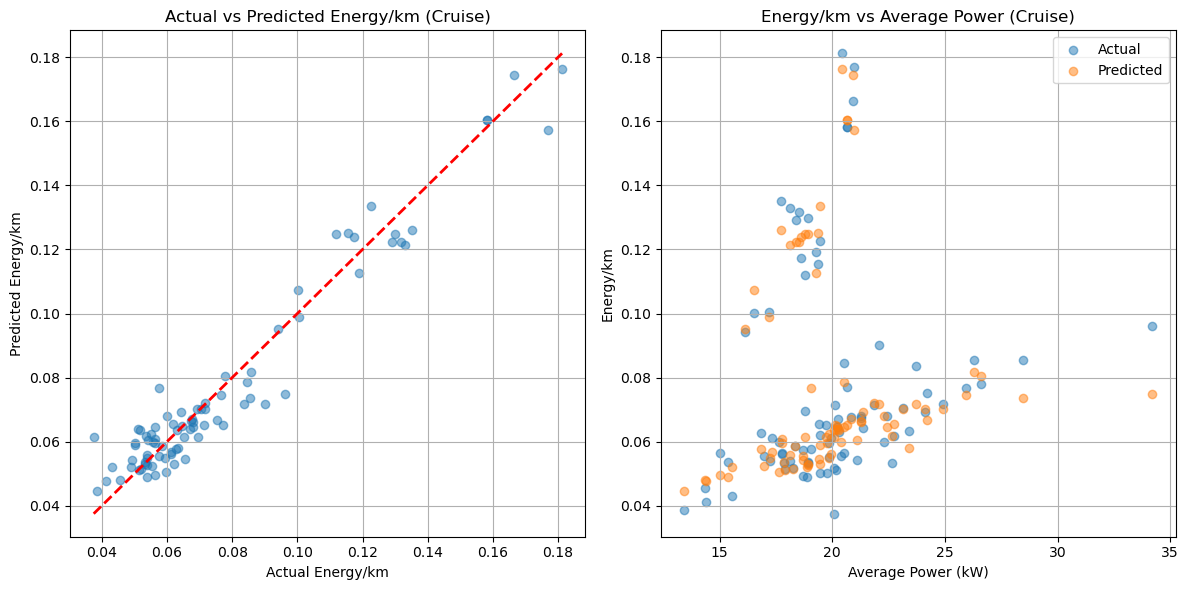

In [400]:
predict_energy_km(cruise_pts(),'cruise')

Processing file C:\Users\Nathan\Documents\PipistrelData\Waterloo\Flight\csv-26897-6263_2024jun03_0920pm_dc [100%]SoH: 0.3529418706893921
Average OAT: 0.018897095695137978
Avg Power: 0.6103985905647278
Avg Headwind: 0.017762431874871254
Mean Squared Error for stage "landing": 1.0776625762909753e-05
R-squared value for stage "landing": 0.92762632868666


<Figure size 1200x400 with 0 Axes>

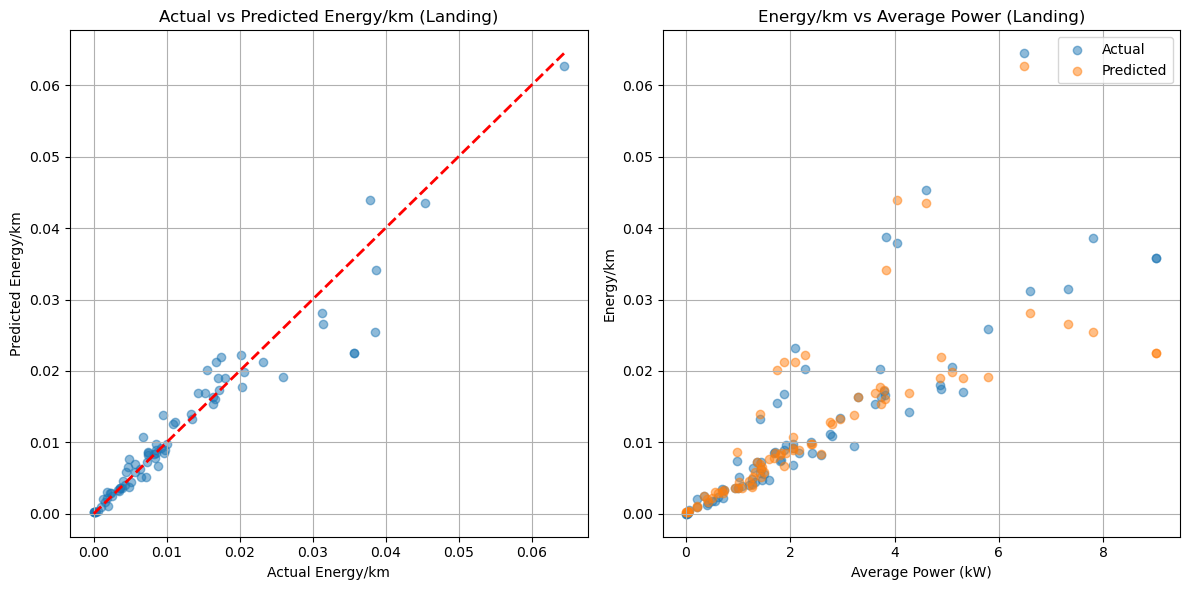

In [42]:
predict_energy_km(landing_pts(),'landing')